# Imports and functions

In [31]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
import distance
from collections import defaultdict
import networkx as nx
from sklearn.metrics import log_loss
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import HashingVectorizer
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from nltk import word_tokenize, ngrams

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import progressbar
from sklearn.model_selection import train_test_split


In [23]:
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")
NB_CORES = 5
FREQ_UPPER_BOUND = 150
NEIGHBOR_UPPER_BOUND = 20

In [4]:
#Some functions for Data visu and losses for the algorithms

def logloss_lgbm(preds, dtrain):
    labels = dtrain.get_label()
    score = 1-log_loss(labels, preds)
    return 'logloss', score,True

def logloss_xgb(preds, dtrain):
    labels = dtrain.get_label()
    score = log_loss(labels, preds)
    return 'logloss', score

def s(y_pred):
    with open("submission_file.csv", 'w') as f:
        f.write("Id,Score\n")
        for i in range(y_pred.shape[0]):
            f.write(str(i)+','+str(y_pred[i][1])+'\n')
def fi(gb,name):
    trace = go.Scatter(
        y = gb.feature_importances_,
        x = features,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 13,
            #size= rf.feature_importances_,
            #color = np.random.randn(500), #set color equal to a variable
            color = gb.feature_importances_,
            colorscale='Portland',
            showscale=True
        ),
        text = features
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= name+' Feature Importance',
        hovermode= 'closest',
         xaxis= dict(
             ticklen= 5,
             showgrid=False,
            zeroline=False,
            showline=False
         ),
        yaxis=dict(
            title= 'Feature Importance',
            showgrid=False,
            zeroline=False,
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')

def simple_test(X):
    if (type(X)==pd.core.frame.DataFrame):
        X = X.values
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y_all, test_size=0.25, random_state=42)

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.02
    params['max_depth'] = 4

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100) 

# Features extraction

In [4]:
# we first use the starting kit to see of there any difference
texts = {}
pairs_train = []
pairs_test = []
y_train = []
with open('train.csv','r', encoding='utf8') as f:
    for line in f:
        l = line.split(',')
        if l[1] not in texts:
            texts[l[1]] = l[3]
        if l[2] not in texts:
            texts[l[2]] = l[4]

        pairs_train.append([l[1],l[2]])

        y_train.append(int(l[5][:-1])) # [:-1] is just to remove formatting at the end


with open('test.csv','r', encoding='utf8') as f:
    for line in f:
        l = line.split(',')
        if l[1] not in texts:
            texts[l[1]] = l[3]
        if l[2] not in texts:
            texts[l[2]] = l[4][:-1]

        pairs_test.append([l[1], l[2]])

In [5]:
def to_stem(v):
    return " ".join([ps.stem(w) for w in word_tokenize(v)])

ps = PorterStemmer()
ids2ind = {} # will contain the row idx of each unique text in the TFIDF matrix 
d2 = {k: to_stem(v) for k, v in texts.items()}
tokenizer = RegexpTokenizer(r'\w+')


for qid in texts:
    ids2ind[qid] = len(ids2ind)

vec = TfidfVectorizer()
A = vec.fit_transform(texts.values())

vec = TfidfVectorizer(stop_words='english')
A1 = vec.fit_transform(texts.values())

vec = TfidfVectorizer()
A3 = vec.fit_transform(d2.values())

vec = HashingVectorizer()
B = vec.fit_transform(texts.values())


In [6]:
N_train = len(pairs_train)
X_train = np.zeros((N_train, 13))
bar = progressbar.ProgressBar(max_value=len(pairs_train))
for i in range(len(pairs_train)):
   
    q1 = pairs_train[i][0]
    q2 = pairs_train[i][1]
    
    l1 = " ".join([ps.stem(w) for w in word_tokenize(texts[q1])])
    l2 = " ".join([ps.stem(w) for w in word_tokenize(texts[q2])])
    
    v1 = ' '.join([word for word in texts[q1].split() if word not in STOP_WORDS])
    v2 = ' '.join([word for word in texts[q2].split() if word not in STOP_WORDS])
    
    X_train[i,0] = cosine_similarity(A[ids2ind[q1],:], A[ids2ind[q2],:])
    X_train[i,1] = cosine_similarity(A1[ids2ind[q1],:], A1[ids2ind[q2],:])
    X_train[i,2] = cosine_similarity(A3[ids2ind[q1],:], A3[ids2ind[q2],:])
    ####################################################################
    X_train[i,3] = cosine_similarity(B[ids2ind[q1],:], B[ids2ind[q2],:])
    ####################################################################
    X_train[i,4] = SequenceMatcher(lambda x: x == " ", texts[q1], texts[q2]).ratio()
    X_train[i,5] = SequenceMatcher(lambda x: x == " ", l1, l2).ratio()
    X_train[i,6] = SequenceMatcher(lambda x: x == " ", v1, v2).ratio()
    ####################################################################
    X_train[i,7] = len(texts[q1].split()) + len(texts[q2].split())/(max(len(texts[q1].split()), len(texts[q2].split())) + SAFE_DIV)
    X_train[i,8] = abs(len(texts[q1].split()) - len(texts[q2].split()))/(min(len(texts[q1].split()), len(texts[q2].split())) + SAFE_DIV)
    X_train[i,9] = len(l1.split()) + len(l2.split())/(max(len(l1.split()), len(l2.split())) + SAFE_DIV)
    X_train[i,10] = abs(len(l1.split()) - len(l2.split()))/(min(len(l1.split()), len(l2.split())) + SAFE_DIV)
    X_train[i,11] = len(v1.split()) + len(v2.split())/(max(len(v1.split()), len(v2.split())) + SAFE_DIV)
    X_train[i,12] = abs(len(v1.split()) - len(v2.split()))/(min(len(v1.split()), len(v2.split())) + SAFE_DIV)
    bar.update(i)

 99% (80095 of 80100) |################## | Elapsed Time: 0:08:37 ETA:  0:00:00

In [7]:
N_test = len(pairs_test)
X_test = np.zeros((N_test, 13))
bar = progressbar.ProgressBar(max_value=len(pairs_test))
for i in range(len(pairs_test)):
    q1 = pairs_test[i][0]
    q2 = pairs_test[i][1]
    
    l1 = " ".join([ps.stem(w) for w in word_tokenize(texts[q1])])
    l2 = " ".join([ps.stem(w) for w in word_tokenize(texts[q2])])
    
    v1 = ' '.join([word for word in texts[q1].split() if word not in STOP_WORDS])
    v2 = ' '.join([word for word in texts[q2].split() if word not in STOP_WORDS])
    
    X_test[i,0] = cosine_similarity(A[ids2ind[q1],:], A[ids2ind[q2],:])
    X_test[i,1] = cosine_similarity(A1[ids2ind[q1],:], A1[ids2ind[q2],:])
    X_test[i,2] = cosine_similarity(A3[ids2ind[q1],:], A3[ids2ind[q2],:])
    ####################################################################
    X_test[i,3] = cosine_similarity(B[ids2ind[q1],:], B[ids2ind[q2],:])
    ####################################################################
    X_test[i,4] = SequenceMatcher(lambda x: x == " ", texts[q1], texts[q2]).ratio()
    X_test[i,5] = SequenceMatcher(lambda x: x == " ", l1, l2).ratio()
    X_test[i,6] = SequenceMatcher(lambda x: x == " ", v1, v2).ratio()
    ####################################################################
    X_test[i,7] = len(texts[q1].split()) + len(texts[q2].split())/(max(len(texts[q1].split()), len(texts[q2].split())) + SAFE_DIV)
    X_test[i,8] = abs(len(texts[q1].split()) - len(texts[q2].split()))/(min(len(texts[q1].split()), len(texts[q2].split())) + SAFE_DIV)
    X_test[i,9] = len(l1.split()) + len(l2.split())/(max(len(l1.split()), len(l2.split())) + SAFE_DIV)
    X_test[i,10] = abs(len(l1.split()) - len(l2.split()))/(min(len(l1.split()), len(l2.split())) + SAFE_DIV)
    X_test[i,11] = len(v1.split()) + len(v2.split())/(max(len(v1.split()), len(v2.split())) + SAFE_DIV)
    X_test[i,12] = abs(len(v1.split()) - len(v2.split()))/(min(len(v1.split()), len(v2.split())) + SAFE_DIV)
    bar.update(i)


 99% (20175 of 20179) |################## | Elapsed Time: 0:02:15 ETA:  0:00:00

In [8]:
#columns=["Tfidf","tfidf_nsw","TfiIdf_stem","Hash","SeqM","SeqM_nsw","SeqM_stem","len","Mean","len_nsw","Mean_nsw","len_stem","Mean_stem"]
X_train_pd = pd.DataFrame(X_train,columns=["Tfidf","tfidf_nsw","TfiIdf_stem","Hash","SeqM","SeqM_nsw","SeqM_stem","len","Mean","len_nsw","Mean_nsw","len_stem","Mean_stem"])
X_train_pd.to_csv("X_train_pd.csv",index = False)

X_test_pd = pd.DataFrame(X_test,columns=["Tfidf","tfidf_nsw","TfiIdf_stem","Hash","SeqM","SeqM_nsw","SeqM_stem","len","Mean","len_nsw","Mean_nsw","len_stem","Mean_stem"])
X_test_pd.to_csv("X_test_pd.csv",index = False)

In [36]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

def get_ngram_features(que1,que2):
    out_list = []
    # get unigram features #
    unigrams_que1 = [word for word in que1.lower().split() if word not in STOP_WORDS]
    unigrams_que2 = [word for word in que2.lower().split() if word not in STOP_WORDS]
    common_unigrams_len = len(set(unigrams_que1).intersection(set(unigrams_que2)))
    out_list.append(common_unigrams_len)
    common_unigrams_ratio = float(common_unigrams_len) / max(len(set(unigrams_que1).union(set(unigrams_que2))),1)
    out_list.append(common_unigrams_ratio)

    # get bigram features #
    bigrams_que1 = [i for i in ngrams(unigrams_que1, 2)]
    bigrams_que2 = [i for i in ngrams(unigrams_que2, 2)]
    common_bigrams_len = len(set(bigrams_que1).intersection(set(bigrams_que2)))
    common_bigrams_ratio = float(common_bigrams_len) / max(len(set(bigrams_que1).union(set(bigrams_que2))),1)
    out_list.append(common_bigrams_len)
    out_list.append(common_bigrams_ratio)

    # get trigram features #
    trigrams_que1 = [i for i in ngrams(unigrams_que1, 3)]
    trigrams_que2 = [i for i in ngrams(unigrams_que2, 3)]
    common_trigrams_len = len(set(trigrams_que1).intersection(set(trigrams_que2)))
    common_trigrams_ratio = float(common_trigrams_len) / max(len(set(trigrams_que1).union(set(trigrams_que2))),1)
    out_list.append(common_trigrams_len)
    out_list.append(common_trigrams_ratio)
    return out_list

def get_token_features(q1, q2):
    token_features = [0.0]*10

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features


def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features")
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))

    print("fuzzy features")
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    print("ngram features ")
    
    ngram_features = df.apply(lambda row: get_ngram_features(str(row['question1']), str(row['question2'])), axis=1)
    df["unigrams_len"]   = list(map(lambda x: x[0], ngram_features))
    df["unigrams_ratio"] = list(map(lambda x: x[1], ngram_features))
    df["bigrams_len"]    = list(map(lambda x: x[2], ngram_features))
    df["bigrams_ratio"]  = list(map(lambda x: x[3], ngram_features))
    df["trigrams_len"]   = list(map(lambda x: x[4], ngram_features))
    df["trigrams_ratio"] = list(map(lambda x: x[5], ngram_features))
    
    return df




print("Extracting features for train:")
train_df = pd.read_csv("train.csv",names =["id", "qid1", "qid2", "question1", "question2", "labels"] )
train_df = extract_features(train_df)
train_df.drop(["id", "qid1", "qid2", "question1", "question2", "labels"], axis=1, inplace=True)
train_df.to_csv("nlp_features_train.csv", index=False)

print("Extracting features for test:")

test_df = pd.read_csv("test.csv",names = ["test_id", "qid1", "qid2", "question1", "question2"])
test_df = extract_features(test_df)
test_df.drop(["test_id", "qid1", "qid2", "question1", "question2"], axis=1, inplace=True)
test_df.to_csv("nlp_features_test.csv", index=False)

Extracting features for train:
token features
fuzzy features
ngram features 
Extracting features for test:
token features
fuzzy features
ngram features 


In [5]:
def create_question_hash(train_df, test_df):
    train_qs = np.dstack([train_df["question1"], train_df["question2"]]).flatten()
    test_qs = np.dstack([test_df["question1"], test_df["question2"]]).flatten()
    all_qs = np.append(train_qs, test_qs)
    all_qs = pd.DataFrame(all_qs)[0].drop_duplicates()
    all_qs.reset_index(inplace=True, drop=True)
    question_dict = pd.Series(all_qs.index.values, index=all_qs.values).to_dict()
    return question_dict


def get_hash(df, hash_dict):
    df["qid1"] = df["question1"].map(hash_dict)
    df["qid2"] = df["question2"].map(hash_dict)
    return df.drop(["question1", "question2"], axis=1)


def get_kcore_dict(df):
    g = nx.Graph()
    g.add_nodes_from(df.qid1)
    edges = list(df[["qid1", "qid2"]].to_records(index=False))
    g.add_edges_from(edges)
    g.remove_edges_from(g.selfloop_edges())

    df_output = pd.DataFrame(data=g.nodes(), columns=["qid"])
    df_output["kcore"] = 0
    for k in range(2, NB_CORES + 1):
        ck = nx.k_core(g, k=k).nodes()
        print("kcore", k)
        df_output.ix[df_output.qid.isin(ck), "kcore"] = k

    return df_output.to_dict()["kcore"]


def get_kcore_features(df, kcore_dict):
    df["kcore1"] = df["qid1"].apply(lambda x: kcore_dict[x])
    df["kcore2"] = df["qid2"].apply(lambda x: kcore_dict[x])
    return df


def convert_to_minmax(df, col):
    sorted_features = np.sort(np.vstack([df[col + "1"], df[col + "2"]]).T)
    df["min_" + col] = sorted_features[:, 0]
    df["max_" + col] = sorted_features[:, 1]
    return df.drop([col + "1", col + "2"], axis=1)


def get_neighbors(train_df, test_df):
    neighbors = defaultdict(set)
    for df in [train_df, test_df]:
        for q1, q2 in zip(df["qid1"], df["qid2"]):
            neighbors[q1].add(q2)
            neighbors[q2].add(q1)
    return neighbors


def get_neighbor_features(df, neighbors):
    common_nc = df.apply(lambda x: len(neighbors[x.qid1].intersection(neighbors[x.qid2])), axis=1)
    min_nc = df.apply(lambda x: min(len(neighbors[x.qid1]), len(neighbors[x.qid2])), axis=1)
    df["common_neighbor_ratio"] = common_nc / min_nc
    df["common_neighbor_count"] = common_nc.apply(lambda x: min(x, NEIGHBOR_UPPER_BOUND))
    return df

def get_pagerank_dic(train_df,test_df):
    g = nx.Graph()
    g.add_nodes_from(train_df.question1)
    g.add_nodes_from(train_df.question2)
    g.add_nodes_from(test_df.question1)
    g.add_nodes_from(test_df.question2)

    g.add_edges_from(train_df[['question1', 'question2']].to_records(index=False))
    g.add_edges_from(test_df[['question1', 'question2']].to_records(index=False))

    d = nx.pagerank(g)
    return d

def get_pagerank_features(df, d):
    pagerank_ratio = df.apply(lambda x: d[x[3]]/d[x[4]],axis=1)
    df["pagerank_ratio"] = pagerank_ratio.apply(lambda x: min(x,100))
    return df


def get_freq_features(df, frequency_map):
    df["freq1"] = df["qid1"].map(lambda x: min(frequency_map[x], FREQ_UPPER_BOUND))
    df["freq2"] = df["qid2"].map(lambda x: min(frequency_map[x], FREQ_UPPER_BOUND))
    return df

def clique(df_tr,df_te):
    G = nx.Graph()
    df =pd.concat([df_tr.iloc[:, :-1], df_te], ignore_index = True)
    edges = [tuple(x) for x in df[['question1', 'question2']].values]
    G.add_edges_from(edges)
    return G

def clique_features(df,G):
    if 'is_duplicate' in df.columns.values:
        map_label = dict(((x[0], x[1]),x[2]) for x in df[['question1', 'question2','is_duplicate']].values)
    else:
         map_label = dict(((x[0], x[1]),0) for x in df[['question1', 'question2']].values)
    map_clique_size = {}
    cliques = sorted(list(nx.find_cliques(G)), key=lambda x: len(x))
    for cli in cliques:
        for q1, q2 in combinations(cli, 2):
            if (q1, q2) in map_label:
                map_clique_size[q1, q2] = len(cli)
            elif (q2, q1) in map_label:
                map_clique_size[q2, q1] = len(cli)

    df['clique_size'] = df.apply(lambda row: map_clique_size.get((row['question1'], row['question2']), -1), axis=1)
    return df

train_df = pd.read_csv("train.csv",names =["id", "qid1", "qid2", "question1", "question2", "is_duplicate"] )
test_df = pd.read_csv("test.csv",names = ["id_test", "qid1", "qid2", "question1", "question2"])

print("Calculating clique features")
G = clique(train_df,test_df)
train_df = clique_features(train_df, G)
test_df = clique_features(test_df, G)


print("Calculating pagerank ratio...")
d = get_pagerank_dic(train_df, test_df)
train_df = get_pagerank_features(train_df, d)
test_df = get_pagerank_features(test_df, d) 

print("Hashing the questions...")
question_dict = create_question_hash(train_df, test_df)
train_df = get_hash(train_df, question_dict)
test_df = get_hash(test_df, question_dict)
print("Number of unique questions:", len(question_dict))

print("Calculating kcore features...")
all_df = pd.concat([train_df, test_df])
kcore_dict = get_kcore_dict(all_df)
train_df = get_kcore_features(train_df, kcore_dict)
test_df = get_kcore_features(test_df, kcore_dict)
train_df = convert_to_minmax(train_df, "kcore")
test_df = convert_to_minmax(test_df, "kcore")

print("Calculating common neighbor features...")
neighbors = get_neighbors(train_df, test_df)
train_df = get_neighbor_features(train_df, neighbors)
test_df = get_neighbor_features(test_df, neighbors)

print("Calculating frequency features...")
frequency_map = dict(zip(*np.unique(np.vstack((all_df["qid1"], all_df["qid2"])), return_counts=True)))
train_df = get_freq_features(train_df, frequency_map)
test_df = get_freq_features(test_df, frequency_map)
train_df = convert_to_minmax(train_df, "freq")
test_df = convert_to_minmax(test_df, "freq")


cols = ["min_kcore", "max_kcore", "common_neighbor_count", "common_neighbor_ratio", "min_freq", "max_freq","pagerank_ratio",'clique_size']
train_df.loc[:, cols].to_csv("non_nlp_features_train.csv", index=False)
test_df.loc[:, cols].to_csv("non_nlp_features_test.csv", index=False)

Calculating clique features
Calculating pagerank ratio...
Hashing the questions...
Number of unique questions: 58869
Calculating kcore features...
kcore 2
kcore 3
kcore 4
kcore 5
kcore 6
kcore 7
kcore 8
kcore 9
kcore 10
kcore 11
kcore 12
kcore 13
kcore 14
kcore 15
kcore 16
kcore 17
kcore 18
kcore 19
kcore 20
kcore 21
kcore 22
kcore 23
kcore 24
kcore 25
kcore 26
kcore 27
kcore 28
kcore 29
kcore 30
Calculating common neighbor features...
Calculating frequency features...


In [1]:
trdf = pd.read_csv('train.csv',names =["id", "qid1", "qid2", "question1", "question2", "is_duplicate"]).iloc[:, :-1]
tedf = pd.read_csv('test.csv',names = ["id_test", "qid1", "qid2", "question1", "question2"])

tr = pd.concat([trdf, tedf], ignore_index = True)

g = nx.Graph()
g.add_nodes_from(tr.question1)
g.add_nodes_from(tr.question2)
edges = list(tr[['question1', 'question2']].to_records(index=False))
g.add_edges_from(edges)

print('Number of unique questions:', len(set(tr.question1) | set(tr.question2)), g.number_of_nodes())
print('Number of rows in the data:', len(tr), g.number_of_edges())

d = g.degree()
print('Mean number of connections:', np.mean([d[k] for k in d]))

def create_q_interactions(name):
    comb['min_'+name] = comb[['q1_'+name, 'q2_'+name]].min(1)
    comb['max_'+name] = comb[['q1_'+name, 'q2_'+name]].max(1)
    comb['mean_'+name] = comb[['q1_'+name, 'q2_'+name]].mean(1)
    comb['sum_'+name] = comb['q1_'+name] + comb['q2_'+name]
    comb['diff_'+name] = abs(comb['q1_'+name] - comb['q2_'+name])

comb = pd.DataFrame()

comb['q1_neighbor_count'] = tr['question1'].map(g.neighbors).map(len)
comb['q2_neighbor_count'] = tr['question2'].map(g.neighbors).map(len)
create_q_interactions('neighbor_count')
comb['shared_neighbor_count'] = tr[['question1', 'question2']].apply(
    lambda x: nx.common_neighbors(g, x.question1, x.question2), 1).apply(lambda x: sum(1 for _ in x))
comb_tr = comb.iloc[:trdf.shape[0], :]
comb_te = comb.iloc[trdf.shape[0]:, :]
comb_te = comb_te.reset_index(drop=True)

comb_tr.to_csv('train_network_neighbors.csv', index=False)
comb_te.to_csv('test_network_neighbors.csv', index=False)


NameError: name 'pd' is not defined

feature extraction took 0.15 minutes
[0]	train-logloss:0.690893	valid-logloss:0.690923
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.618475	valid-logloss:0.621174
[200]	train-logloss:0.598369	valid-logloss:0.603393
[300]	train-logloss:0.583407	valid-logloss:0.590596


In [37]:
print("Train features are being merged")
train_groupe_2 = pd.read_csv("nlp_features_train.csv")
train_groupe_3 = pd.read_csv("non_nlp_features_train.csv")
train_groupe_1 = pd.read_csv("X_train_pd.csv")
train_groupe_4 = pd.read_csv('train_network_neighbors.csv')

X_train = np.hstack((train_groupe_1 ,train_groupe_2 ,train_groupe_3,train_groupe_4))
print(X_train.shape)


Train features are being merged
(80100, 50)


In [38]:
print("Test features are being merged")
test_groupe_2 = pd.read_csv("nlp_features_test.csv")
test_groupe_3 = pd.read_csv("non_nlp_features_test.csv")
test_groupe_1 = pd.read_csv("X_test_pd.csv")
test_groupe_4 = pd.read_csv('test_network_neighbors.csv')

X_test = np.hstack((test_groupe_1,test_groupe_2, test_groupe_3,test_groupe_4))
print(X_test.shape)

Test features are being merged
(20179, 50)


In [39]:
train_df = pd.read_csv("train.csv",names =["id", "qid1", "qid2", "question1", "question2", "is_duplicate"])
Y = np.array(train_df["is_duplicate"])
Y_all = Y
Y.shape

(80100,)

In [9]:
X_train, X_v, Y, y_v = train_test_split(X_train, Y[:X_train.shape[0]], test_size=0.1,random_state = 42)

# Some exploration

In [10]:
print(texts[pairs_train[50][0]])
print(texts[pairs_train[50][1]])

NameError: name 'texts' is not defined

In [11]:
data = [go.Bar(
            x = train_df["is_duplicate"].value_counts().index.values,
            y = train_df["is_duplicate"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

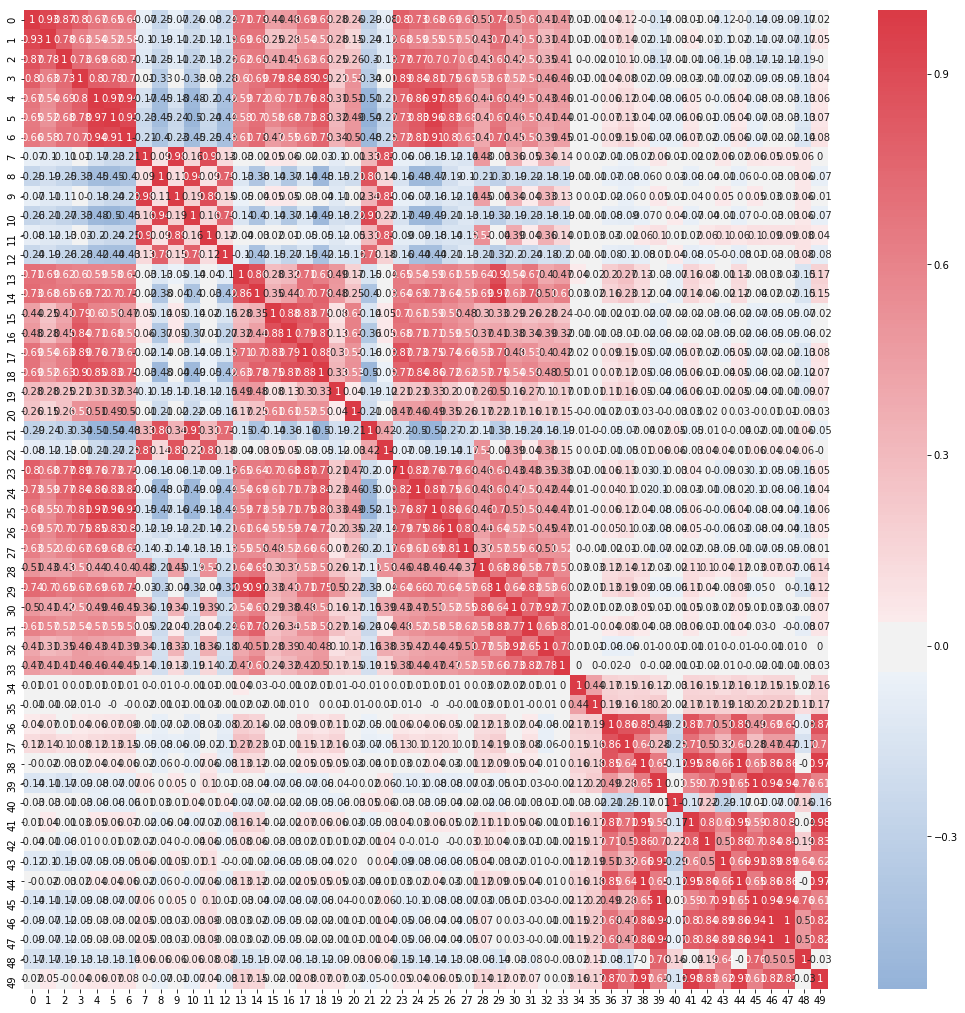

In [40]:
### Corralation matrix heatmap
# Getting correlation matrix
cor_matrix = pd.DataFrame(X_train).corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(18,18));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=5, min_samples_leaf=5, max_features=10, n_jobs=-1, random_state=0)
rf.fit(X_train,Y)
features = np.concatenate((train_groupe_1.columns.values ,train_groupe_2.columns.values ,train_groupe_3.columns.values,train_groupe_4.columns.values))
print("----- Training Done -----Printing Score")
print(rf.score(X_train,Y))

----- Training Done -----Printing Score
0.912222222222


In [42]:
# Scatter plot 
fi(rf,'Random Forest')

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=150, max_depth=5, min_samples_leaf=5, max_features=10, random_state=0)
gb.fit(X_train,Y)
print("----- Training Done -----Printing Score")
print(gb.score(X_train,Y))

----- Training Done -----Printing Score
0.932784019975


In [44]:
fi(gb,'Gradient Boosting Machine')

In [45]:
simple_test(train_groupe_1)

[0]	train-logloss:0.687785	valid-logloss:0.687851
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.530284	valid-logloss:0.533841
[200]	train-logloss:0.511097	valid-logloss:0.516636
[300]	train-logloss:0.501265	valid-logloss:0.50907


In [46]:
simple_test(train_groupe_2)

[0]	train-logloss:0.685189	valid-logloss:0.68516
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.463671	valid-logloss:0.462741
[200]	train-logloss:0.444934	valid-logloss:0.445295
[300]	train-logloss:0.436977	valid-logloss:0.438886


In [47]:
simple_test(train_groupe_3)

[0]	train-logloss:0.679325	valid-logloss:0.679392
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.27067	valid-logloss:0.274026
[200]	train-logloss:0.236404	valid-logloss:0.24105
[300]	train-logloss:0.231769	valid-logloss:0.237334


In [48]:
simple_test(train_groupe_4)

[0]	train-logloss:0.679398	valid-logloss:0.679452
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.274666	valid-logloss:0.277213
[200]	train-logloss:0.241925	valid-logloss:0.245165
[300]	train-logloss:0.237835	valid-logloss:0.2415


In [49]:
simple_test(np.hstack((train_groupe_1,train_groupe_2,train_groupe_3,train_groupe_4)))

[0]	train-logloss:0.678474	valid-logloss:0.678536
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.231384	valid-logloss:0.235719
[200]	train-logloss:0.183936	valid-logloss:0.19135
[300]	train-logloss:0.171289	valid-logloss:0.180893


# Algo

In [54]:
def transform(X):
        bar = progressbar.ProgressBar(max_value=len(X))
        X_ = np.zeros((len(X),len(X[1])+2*len(X[1])))
        d_median = np.median(X,axis=0)
        d_mean = np.mean(X,axis=0)
        for i in range(len(X)):
            m = []
            for j in range(len(X[i])):
                m.append((X[i,j] > d_median[j]).astype(np.int))
                m.append((X[i,j] > d_mean[j]).astype(np.int))
            X_[i] = np.concatenate((np.array(X[i]),np.array(m)))
            bar.update(i)
        return X_


In [55]:
X_train = transform(X_train)  

 99% (79628 of 80100) |################## | Elapsed Time: 0:00:09 ETA:  0:00:00

In [56]:
X_test = transform(X_test) 

 98% (19924 of 20179) |################## | Elapsed Time: 0:00:02 ETA:  0:00:00

In [57]:
X_train.shape

(80100, 150)

In [58]:
X_v = transform(X_v)

 93% (7504 of 8010) |###################  | Elapsed Time: 0:00:00 ETA:  0:00:00

In [69]:
X_v.shape

(8010, 132)

In [59]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import lightgbm as lgb
######################################################


### LGB modeling
params2 = {'learning_rate': 0.025,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 10,
          'num_leaves': 25,        
          'min_data_in_leaf': 200, 
          'boosting': 'gbdt',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}

params1 = {'learning_rate': 0.025,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 7,
          'num_leaves': 16,        
          'min_data_in_leaf': 150, 
          'boosting': 'goss',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}
MAX_TREES = 5000

class Classifier1(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        watchlist = [(lgb.Dataset(x1, label=y1), 'train'), (lgb.Dataset(x2, label=y2), 'valid')]
        self.clf2 = lgb.train(params2, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
        self.clf1 = lgb.train(params1, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
    def predict(self, X):
        return self.clf1.predict(X)

    def predict_proba(self, X):
        res1 = self.clf1.predict(X, num_iteration = self.clf1.best_iteration)
        res2 = self.clf2.predict(X,num_iteration = self.clf2.best_iteration)
        return [0.5*(a+b) for a,b in zip(res1,res2)]
        
    
classifier1 = Classifier1()
classifier1.fit(X_train,Y)
pred1 = classifier1.predict_proba(X_test)



Training until validation scores don't improve for 300 rounds.
[100]	valid_0's binary_logloss: 0.205495	valid_0's logloss: 0.794505
[200]	valid_0's binary_logloss: 0.173807	valid_0's logloss: 0.826193
[300]	valid_0's binary_logloss: 0.168984	valid_0's logloss: 0.831016
[400]	valid_0's binary_logloss: 0.167357	valid_0's logloss: 0.832643
[500]	valid_0's binary_logloss: 0.166441	valid_0's logloss: 0.833559
[600]	valid_0's binary_logloss: 0.165699	valid_0's logloss: 0.834301
[700]	valid_0's binary_logloss: 0.165419	valid_0's logloss: 0.834581
[800]	valid_0's binary_logloss: 0.164997	valid_0's logloss: 0.835003
[900]	valid_0's binary_logloss: 0.164726	valid_0's logloss: 0.835274
[1000]	valid_0's binary_logloss: 0.164626	valid_0's logloss: 0.835374
[1100]	valid_0's binary_logloss: 0.164579	valid_0's logloss: 0.835421
[1200]	valid_0's binary_logloss: 0.16458	valid_0's logloss: 0.83542
[1300]	valid_0's binary_logloss: 0.16474	valid_0's logloss: 0.83526
Early stopping, best iteration is:
[1054

In [60]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
######################################################
### XGB modeling
params = {'eta': 0.01,
          'max_depth': 7, 
          'subsample': 0.7, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':100,
          'alpha':0,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
params2 = {'eta': 0.025,
          'max_depth': 10, 
          'subsample': 0.7, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':150,
          'alpha':1,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
######################################################
class Classifier2(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
        self.clf1 = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=200)
        self.clf2 = xgb.train(params2, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=200)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        res = [(r1+r2)*0.5 for r1,r2 in zip(res1,res2)]
        return np.array([ [1-c,c] for c in res])
    
classifier2 = Classifier2()
classifier2.fit(X_train,Y)
pred2 = classifier2.predict_proba(X_test)

[0]	train-logloss:0.685773	valid-logloss:0.68578
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.325724	valid-logloss:0.327018
[200]	train-logloss:0.228082	valid-logloss:0.230417
[300]	train-logloss:0.194204	valid-logloss:0.197683
[400]	train-logloss:0.180643	valid-logloss:0.18522
[500]	train-logloss:0.174057	valid-logloss:0.179492
[600]	train-logloss:0.170684	valid-logloss:0.17683
[700]	train-logloss:0.168166	valid-logloss:0.175114
[800]	train-logloss:0.166165	valid-logloss:0.174008
[900]	train-logloss:0.164347	valid-logloss:0.173062
[1000]	train-logloss:0.162743	valid-logloss:0.172317
[1100]	train-logloss:0.161365	valid-logloss:0.171828
[1200]	train-logloss:0.160071	valid-logloss:0.171372
[1300]	train-logloss:0.158906	valid-logloss:0.170937
[1400]	train-logloss:0.157821	valid-logloss:0.170614
[1500]	train-logloss:0.156785	valid-logloss:0.170325
[1600]	train-lo

In [61]:
from sklearn.base import BaseEstimator
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

class Classifier3(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        self.clf1 = CatBoostClassifier(iterations=2000,learning_rate=0.015, depth=8, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf1.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
        self.clf2 = CatBoostClassifier(iterations=2000,learning_rate=0.015, depth=10, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf2.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return [(v[1]+l[1])*0.5 for v,l in zip(self.clf2.predict_proba(X),self.clf1.predict_proba(X))]

classifier3 = Classifier3()
classifier3.fit(X_train,Y)
pred3 = classifier3.predict_proba(X_test)

0: learn: 0.6629468	test: 0.6628634	bestTest: 0.6628634 (0)	total: 304ms	remaining: 10m 7s
1: learn: 0.6354428	test: 0.6353597	bestTest: 0.6353597 (1)	total: 584ms	remaining: 9m 43s
2: learn: 0.6104486	test: 0.6103743	bestTest: 0.6103743 (2)	total: 883ms	remaining: 9m 47s
3: learn: 0.5883372	test: 0.5882705	bestTest: 0.5882705 (3)	total: 1.17s	remaining: 9m 41s
4: learn: 0.5646642	test: 0.5645736	bestTest: 0.5645736 (4)	total: 1.44s	remaining: 9m 34s
5: learn: 0.5428604	test: 0.5426715	bestTest: 0.5426715 (5)	total: 1.72s	remaining: 9m 30s
6: learn: 0.5265072	test: 0.5264112	bestTest: 0.5264112 (6)	total: 1.99s	remaining: 9m 26s
7: learn: 0.5095785	test: 0.5095649	bestTest: 0.5095649 (7)	total: 2.31s	remaining: 9m 36s
8: learn: 0.4938468	test: 0.493827	bestTest: 0.493827 (8)	total: 2.6s	remaining: 9m 34s
9: learn: 0.4755595	test: 0.4755637	bestTest: 0.4755637 (9)	total: 2.88s	remaining: 9m 33s
10: learn: 0.4589848	test: 0.4591021	bestTest: 0.4591021 (10)	total: 3.15s	remaining: 9m 30s


90: learn: 0.1938098	test: 0.1966062	bestTest: 0.1966062 (90)	total: 25.8s	remaining: 9m 1s
91: learn: 0.1933785	test: 0.1961884	bestTest: 0.1961884 (91)	total: 26.1s	remaining: 9m
92: learn: 0.1930314	test: 0.195857	bestTest: 0.195857 (92)	total: 26.3s	remaining: 9m
93: learn: 0.1925541	test: 0.1954355	bestTest: 0.1954355 (93)	total: 26.7s	remaining: 9m
94: learn: 0.1921264	test: 0.1950436	bestTest: 0.1950436 (94)	total: 27s	remaining: 9m
95: learn: 0.1917478	test: 0.1946916	bestTest: 0.1946916 (95)	total: 27.2s	remaining: 9m
96: learn: 0.1913827	test: 0.1943438	bestTest: 0.1943438 (96)	total: 27.5s	remaining: 9m
97: learn: 0.1910922	test: 0.1940669	bestTest: 0.1940669 (97)	total: 27.8s	remaining: 8m 59s
98: learn: 0.1907174	test: 0.1937403	bestTest: 0.1937403 (98)	total: 28.1s	remaining: 8m 59s
99: learn: 0.1902472	test: 0.1933171	bestTest: 0.1933171 (99)	total: 28.4s	remaining: 8m 59s
100: learn: 0.1898946	test: 0.1930112	bestTest: 0.1930112 (100)	total: 28.7s	remaining: 8m 59s
101:

178: learn: 0.1746886	test: 0.1802436	bestTest: 0.1802436 (178)	total: 51.4s	remaining: 8m 42s
179: learn: 0.1745809	test: 0.1801617	bestTest: 0.1801617 (179)	total: 51.6s	remaining: 8m 42s
180: learn: 0.1744727	test: 0.1800569	bestTest: 0.1800569 (180)	total: 51.9s	remaining: 8m 41s
181: learn: 0.174364	test: 0.1799659	bestTest: 0.1799659 (181)	total: 52.2s	remaining: 8m 41s
182: learn: 0.1742523	test: 0.1798862	bestTest: 0.1798862 (182)	total: 52.5s	remaining: 8m 41s
183: learn: 0.1741541	test: 0.1798028	bestTest: 0.1798028 (183)	total: 52.8s	remaining: 8m 41s
184: learn: 0.1740481	test: 0.1797221	bestTest: 0.1797221 (184)	total: 53.1s	remaining: 8m 40s
185: learn: 0.1739415	test: 0.1796682	bestTest: 0.1796682 (185)	total: 53.4s	remaining: 8m 40s
186: learn: 0.1738476	test: 0.179602	bestTest: 0.179602 (186)	total: 53.6s	remaining: 8m 39s
187: learn: 0.1737645	test: 0.1795346	bestTest: 0.1795346 (187)	total: 53.9s	remaining: 8m 39s
188: learn: 0.1736772	test: 0.1794595	bestTest: 0.179

265: learn: 0.1682987	test: 0.1756031	bestTest: 0.1756031 (265)	total: 1m 16s	remaining: 8m 20s
266: learn: 0.1682491	test: 0.1755662	bestTest: 0.1755662 (266)	total: 1m 17s	remaining: 8m 19s
267: learn: 0.1681815	test: 0.1755213	bestTest: 0.1755213 (267)	total: 1m 17s	remaining: 8m 19s
268: learn: 0.1681363	test: 0.1754824	bestTest: 0.1754824 (268)	total: 1m 17s	remaining: 8m 19s
269: learn: 0.1680698	test: 0.1754384	bestTest: 0.1754384 (269)	total: 1m 17s	remaining: 8m 19s
270: learn: 0.1680107	test: 0.1754046	bestTest: 0.1754046 (270)	total: 1m 18s	remaining: 8m 19s
271: learn: 0.167953	test: 0.1753578	bestTest: 0.1753578 (271)	total: 1m 18s	remaining: 8m 19s
272: learn: 0.1678854	test: 0.1753175	bestTest: 0.1753175 (272)	total: 1m 18s	remaining: 8m 19s
273: learn: 0.167842	test: 0.1752829	bestTest: 0.1752829 (273)	total: 1m 19s	remaining: 8m 18s
274: learn: 0.1677887	test: 0.1752541	bestTest: 0.1752541 (274)	total: 1m 19s	remaining: 8m 18s
275: learn: 0.1677385	test: 0.1752145	best

352: learn: 0.1641639	test: 0.1730481	bestTest: 0.1730481 (352)	total: 1m 41s	remaining: 7m 53s
353: learn: 0.1641208	test: 0.1730288	bestTest: 0.1730288 (353)	total: 1m 41s	remaining: 7m 53s
354: learn: 0.1640911	test: 0.1730057	bestTest: 0.1730057 (354)	total: 1m 42s	remaining: 7m 52s
355: learn: 0.1640433	test: 0.1729868	bestTest: 0.1729868 (355)	total: 1m 42s	remaining: 7m 52s
356: learn: 0.1640007	test: 0.1729663	bestTest: 0.1729663 (356)	total: 1m 42s	remaining: 7m 52s
357: learn: 0.1639535	test: 0.1729377	bestTest: 0.1729377 (357)	total: 1m 42s	remaining: 7m 51s
358: learn: 0.1639155	test: 0.1729194	bestTest: 0.1729194 (358)	total: 1m 43s	remaining: 7m 51s
359: learn: 0.16388	test: 0.172905	bestTest: 0.172905 (359)	total: 1m 43s	remaining: 7m 51s
360: learn: 0.1638109	test: 0.1728904	bestTest: 0.1728904 (360)	total: 1m 43s	remaining: 7m 51s
361: learn: 0.1637737	test: 0.1728703	bestTest: 0.1728703 (361)	total: 1m 44s	remaining: 7m 50s
362: learn: 0.1637404	test: 0.1728503	bestTe

438: learn: 0.1608673	test: 0.1714014	bestTest: 0.1714014 (438)	total: 2m 5s	remaining: 7m 25s
439: learn: 0.1608375	test: 0.1713895	bestTest: 0.1713895 (439)	total: 2m 5s	remaining: 7m 25s
440: learn: 0.1608118	test: 0.1713809	bestTest: 0.1713809 (440)	total: 2m 5s	remaining: 7m 24s
441: learn: 0.1607867	test: 0.1713686	bestTest: 0.1713686 (441)	total: 2m 6s	remaining: 7m 24s
442: learn: 0.1607563	test: 0.1713482	bestTest: 0.1713482 (442)	total: 2m 6s	remaining: 7m 24s
443: learn: 0.1606895	test: 0.1713257	bestTest: 0.1713257 (443)	total: 2m 6s	remaining: 7m 24s
444: learn: 0.1606614	test: 0.171308	bestTest: 0.171308 (444)	total: 2m 6s	remaining: 7m 23s
445: learn: 0.160643	test: 0.1712939	bestTest: 0.1712939 (445)	total: 2m 7s	remaining: 7m 23s
446: learn: 0.1606155	test: 0.1712834	bestTest: 0.1712834 (446)	total: 2m 7s	remaining: 7m 22s
447: learn: 0.1605944	test: 0.1712634	bestTest: 0.1712634 (447)	total: 2m 7s	remaining: 7m 23s
448: learn: 0.1605396	test: 0.1712358	bestTest: 0.171

525: learn: 0.1580865	test: 0.1701899	bestTest: 0.1701899 (525)	total: 2m 29s	remaining: 6m 59s
526: learn: 0.1580681	test: 0.1701813	bestTest: 0.1701813 (526)	total: 2m 29s	remaining: 6m 59s
527: learn: 0.1580458	test: 0.1701745	bestTest: 0.1701745 (527)	total: 2m 30s	remaining: 6m 58s
528: learn: 0.1580303	test: 0.1701686	bestTest: 0.1701686 (528)	total: 2m 30s	remaining: 6m 58s
529: learn: 0.1580122	test: 0.1701628	bestTest: 0.1701628 (529)	total: 2m 30s	remaining: 6m 58s
530: learn: 0.1579867	test: 0.1701621	bestTest: 0.1701621 (530)	total: 2m 31s	remaining: 6m 57s
531: learn: 0.1579466	test: 0.1701471	bestTest: 0.1701471 (531)	total: 2m 31s	remaining: 6m 57s
532: learn: 0.1579239	test: 0.1701374	bestTest: 0.1701374 (532)	total: 2m 31s	remaining: 6m 57s
533: learn: 0.1578825	test: 0.1701222	bestTest: 0.1701222 (533)	total: 2m 31s	remaining: 6m 56s
534: learn: 0.1578449	test: 0.1701066	bestTest: 0.1701066 (534)	total: 2m 32s	remaining: 6m 56s
535: learn: 0.157821	test: 0.1701008	bes

611: learn: 0.1557334	test: 0.1693868	bestTest: 0.1693868 (611)	total: 2m 53s	remaining: 6m 33s
612: learn: 0.155705	test: 0.1693871	bestTest: 0.1693868 (611)	total: 2m 53s	remaining: 6m 32s
613: learn: 0.1556814	test: 0.1693761	bestTest: 0.1693761 (613)	total: 2m 53s	remaining: 6m 32s
614: learn: 0.1556652	test: 0.1693661	bestTest: 0.1693661 (614)	total: 2m 54s	remaining: 6m 32s
615: learn: 0.155629	test: 0.1693472	bestTest: 0.1693472 (615)	total: 2m 54s	remaining: 6m 32s
616: learn: 0.1556136	test: 0.1693445	bestTest: 0.1693445 (616)	total: 2m 54s	remaining: 6m 31s
617: learn: 0.1555921	test: 0.1693304	bestTest: 0.1693304 (617)	total: 2m 55s	remaining: 6m 31s
618: learn: 0.1555626	test: 0.1693197	bestTest: 0.1693197 (618)	total: 2m 55s	remaining: 6m 31s
619: learn: 0.1555241	test: 0.1693181	bestTest: 0.1693181 (619)	total: 2m 55s	remaining: 6m 30s
620: learn: 0.1555054	test: 0.1693157	bestTest: 0.1693157 (620)	total: 2m 55s	remaining: 6m 30s
621: learn: 0.1554671	test: 0.1693047	best

698: learn: 0.1532337	test: 0.1686851	bestTest: 0.1686851 (698)	total: 3m 17s	remaining: 6m 6s
699: learn: 0.1532039	test: 0.1686702	bestTest: 0.1686702 (699)	total: 3m 17s	remaining: 6m 6s
700: learn: 0.1531914	test: 0.1686648	bestTest: 0.1686648 (700)	total: 3m 17s	remaining: 6m 6s
701: learn: 0.1531608	test: 0.1686589	bestTest: 0.1686589 (701)	total: 3m 17s	remaining: 6m 6s
702: learn: 0.1531489	test: 0.1686523	bestTest: 0.1686523 (702)	total: 3m 18s	remaining: 6m 5s
703: learn: 0.1531231	test: 0.1686421	bestTest: 0.1686421 (703)	total: 3m 18s	remaining: 6m 5s
704: learn: 0.1531023	test: 0.168629	bestTest: 0.168629 (704)	total: 3m 18s	remaining: 6m 5s
705: learn: 0.1530771	test: 0.1686285	bestTest: 0.1686285 (705)	total: 3m 19s	remaining: 6m 4s
706: learn: 0.153036	test: 0.1686332	bestTest: 0.1686285 (705)	total: 3m 19s	remaining: 6m 4s
707: learn: 0.1530036	test: 0.1686155	bestTest: 0.1686155 (707)	total: 3m 19s	remaining: 6m 4s
708: learn: 0.1529877	test: 0.1686121	bestTest: 0.168

784: learn: 0.1507952	test: 0.1680769	bestTest: 0.1680688 (782)	total: 3m 40s	remaining: 5m 41s
785: learn: 0.1507589	test: 0.1680715	bestTest: 0.1680688 (782)	total: 3m 40s	remaining: 5m 41s
786: learn: 0.1507266	test: 0.168059	bestTest: 0.168059 (786)	total: 3m 41s	remaining: 5m 40s
787: learn: 0.1506814	test: 0.1680417	bestTest: 0.1680417 (787)	total: 3m 41s	remaining: 5m 40s
788: learn: 0.1506307	test: 0.1680236	bestTest: 0.1680236 (788)	total: 3m 41s	remaining: 5m 40s
789: learn: 0.1506032	test: 0.1680048	bestTest: 0.1680048 (789)	total: 3m 41s	remaining: 5m 39s
790: learn: 0.1505653	test: 0.1679969	bestTest: 0.1679969 (790)	total: 3m 42s	remaining: 5m 39s
791: learn: 0.1505344	test: 0.1679914	bestTest: 0.1679914 (791)	total: 3m 42s	remaining: 5m 39s
792: learn: 0.1505117	test: 0.1679774	bestTest: 0.1679774 (792)	total: 3m 42s	remaining: 5m 39s
793: learn: 0.1504884	test: 0.1679748	bestTest: 0.1679748 (793)	total: 3m 43s	remaining: 5m 38s
794: learn: 0.1504657	test: 0.1679715	best

870: learn: 0.1484435	test: 0.1674817	bestTest: 0.1674801 (869)	total: 4m 4s	remaining: 5m 16s
871: learn: 0.1484081	test: 0.1674811	bestTest: 0.1674801 (869)	total: 4m 4s	remaining: 5m 16s
872: learn: 0.148361	test: 0.1674754	bestTest: 0.1674754 (872)	total: 4m 4s	remaining: 5m 15s
873: learn: 0.1483384	test: 0.1674681	bestTest: 0.1674681 (873)	total: 4m 4s	remaining: 5m 15s
874: learn: 0.1483063	test: 0.1674546	bestTest: 0.1674546 (874)	total: 4m 5s	remaining: 5m 15s
875: learn: 0.14828	test: 0.1674551	bestTest: 0.1674546 (874)	total: 4m 5s	remaining: 5m 14s
876: learn: 0.1482631	test: 0.1674497	bestTest: 0.1674497 (876)	total: 4m 5s	remaining: 5m 14s
877: learn: 0.1482501	test: 0.1674452	bestTest: 0.1674452 (877)	total: 4m 5s	remaining: 5m 14s
878: learn: 0.1482207	test: 0.1674383	bestTest: 0.1674383 (878)	total: 4m 6s	remaining: 5m 14s
879: learn: 0.1481752	test: 0.1674132	bestTest: 0.1674132 (879)	total: 4m 6s	remaining: 5m 13s
880: learn: 0.1481392	test: 0.1674095	bestTest: 0.167

957: learn: 0.146061	test: 0.167034	bestTest: 0.167034 (957)	total: 4m 27s	remaining: 4m 50s
958: learn: 0.1460355	test: 0.1670349	bestTest: 0.167034 (957)	total: 4m 27s	remaining: 4m 50s
959: learn: 0.1460063	test: 0.167023	bestTest: 0.167023 (959)	total: 4m 28s	remaining: 4m 50s
960: learn: 0.1459844	test: 0.1670233	bestTest: 0.167023 (959)	total: 4m 28s	remaining: 4m 50s
961: learn: 0.1459523	test: 0.1670184	bestTest: 0.1670184 (961)	total: 4m 28s	remaining: 4m 49s
962: learn: 0.1459346	test: 0.1670212	bestTest: 0.1670184 (961)	total: 4m 28s	remaining: 4m 49s
963: learn: 0.1458902	test: 0.1670082	bestTest: 0.1670082 (963)	total: 4m 29s	remaining: 4m 49s
964: learn: 0.145869	test: 0.1670035	bestTest: 0.1670035 (964)	total: 4m 29s	remaining: 4m 48s
965: learn: 0.1458496	test: 0.1669949	bestTest: 0.1669949 (965)	total: 4m 29s	remaining: 4m 48s
966: learn: 0.1458354	test: 0.1669863	bestTest: 0.1669863 (966)	total: 4m 29s	remaining: 4m 48s
967: learn: 0.1458124	test: 0.1669839	bestTest: 

1042: learn: 0.1439238	test: 0.1665713	bestTest: 0.1665626 (1041)	total: 4m 50s	remaining: 4m 26s
1043: learn: 0.1439074	test: 0.1665679	bestTest: 0.1665626 (1041)	total: 4m 50s	remaining: 4m 26s
1044: learn: 0.1438839	test: 0.1665665	bestTest: 0.1665626 (1041)	total: 4m 50s	remaining: 4m 25s
1045: learn: 0.1438589	test: 0.166556	bestTest: 0.166556 (1045)	total: 4m 51s	remaining: 4m 25s
1046: learn: 0.1438207	test: 0.1665491	bestTest: 0.1665491 (1046)	total: 4m 51s	remaining: 4m 25s
1047: learn: 0.1437848	test: 0.1665489	bestTest: 0.1665489 (1047)	total: 4m 51s	remaining: 4m 24s
1048: learn: 0.1437685	test: 0.1665541	bestTest: 0.1665489 (1047)	total: 4m 51s	remaining: 4m 24s
1049: learn: 0.1437466	test: 0.1665449	bestTest: 0.1665449 (1049)	total: 4m 52s	remaining: 4m 24s
1050: learn: 0.1437279	test: 0.1665522	bestTest: 0.1665449 (1049)	total: 4m 52s	remaining: 4m 23s
1051: learn: 0.1436939	test: 0.1665432	bestTest: 0.1665432 (1051)	total: 4m 52s	remaining: 4m 23s
1052: learn: 0.1436726

1127: learn: 0.1419756	test: 0.1662925	bestTest: 0.1662925 (1127)	total: 5m 13s	remaining: 4m 2s
1128: learn: 0.1419535	test: 0.1662879	bestTest: 0.1662879 (1128)	total: 5m 13s	remaining: 4m 1s
1129: learn: 0.1419234	test: 0.1662805	bestTest: 0.1662805 (1129)	total: 5m 13s	remaining: 4m 1s
1130: learn: 0.1418972	test: 0.1662763	bestTest: 0.1662763 (1130)	total: 5m 14s	remaining: 4m 1s
1131: learn: 0.1418862	test: 0.1662759	bestTest: 0.1662759 (1131)	total: 5m 14s	remaining: 4m 1s
1132: learn: 0.1418685	test: 0.1662766	bestTest: 0.1662759 (1131)	total: 5m 14s	remaining: 4m
1133: learn: 0.1418484	test: 0.1662728	bestTest: 0.1662728 (1133)	total: 5m 14s	remaining: 4m
1134: learn: 0.1418276	test: 0.1662701	bestTest: 0.1662701 (1134)	total: 5m 15s	remaining: 4m
1135: learn: 0.1418017	test: 0.1662577	bestTest: 0.1662577 (1135)	total: 5m 15s	remaining: 3m 59s
1136: learn: 0.1417797	test: 0.1662508	bestTest: 0.1662508 (1136)	total: 5m 15s	remaining: 3m 59s
1137: learn: 0.1417717	test: 0.166247

1212: learn: 0.1400033	test: 0.1660121	bestTest: 0.1660121 (1212)	total: 5m 36s	remaining: 3m 38s
1213: learn: 0.1399881	test: 0.1660148	bestTest: 0.1660121 (1212)	total: 5m 37s	remaining: 3m 38s
1214: learn: 0.1399748	test: 0.1660106	bestTest: 0.1660106 (1214)	total: 5m 37s	remaining: 3m 38s
1215: learn: 0.139964	test: 0.1660058	bestTest: 0.1660058 (1215)	total: 5m 37s	remaining: 3m 37s
1216: learn: 0.139934	test: 0.1660039	bestTest: 0.1660039 (1216)	total: 5m 37s	remaining: 3m 37s
1217: learn: 0.1399155	test: 0.1660071	bestTest: 0.1660039 (1216)	total: 5m 38s	remaining: 3m 37s
1218: learn: 0.1398761	test: 0.1660002	bestTest: 0.1660002 (1218)	total: 5m 38s	remaining: 3m 36s
1219: learn: 0.1398657	test: 0.1660008	bestTest: 0.1660002 (1218)	total: 5m 38s	remaining: 3m 36s
1220: learn: 0.1398428	test: 0.1659987	bestTest: 0.1659987 (1220)	total: 5m 39s	remaining: 3m 36s
1221: learn: 0.1398063	test: 0.1659981	bestTest: 0.1659981 (1221)	total: 5m 39s	remaining: 3m 36s
1222: learn: 0.1397928

1296: learn: 0.1381866	test: 0.1658238	bestTest: 0.1658238 (1296)	total: 6m 1s	remaining: 3m 15s
1297: learn: 0.1381607	test: 0.1658223	bestTest: 0.1658223 (1297)	total: 6m 1s	remaining: 3m 15s
1298: learn: 0.138132	test: 0.1658153	bestTest: 0.1658153 (1298)	total: 6m 1s	remaining: 3m 15s
1299: learn: 0.1381005	test: 0.1658123	bestTest: 0.1658123 (1299)	total: 6m 1s	remaining: 3m 14s
1300: learn: 0.1380896	test: 0.1658115	bestTest: 0.1658115 (1300)	total: 6m 2s	remaining: 3m 14s
1301: learn: 0.1380748	test: 0.165805	bestTest: 0.165805 (1301)	total: 6m 2s	remaining: 3m 14s
1302: learn: 0.1380506	test: 0.1658106	bestTest: 0.165805 (1301)	total: 6m 2s	remaining: 3m 14s
1303: learn: 0.13803	test: 0.1658099	bestTest: 0.165805 (1301)	total: 6m 3s	remaining: 3m 13s
1304: learn: 0.1379951	test: 0.1658045	bestTest: 0.1658045 (1304)	total: 6m 3s	remaining: 3m 13s
1305: learn: 0.1379795	test: 0.1658002	bestTest: 0.1658002 (1305)	total: 6m 3s	remaining: 3m 13s
1306: learn: 0.137964	test: 0.1657953

1381: learn: 0.1364329	test: 0.1655987	bestTest: 0.1655987 (1381)	total: 6m 25s	remaining: 2m 52s
1382: learn: 0.1364138	test: 0.1655861	bestTest: 0.1655861 (1382)	total: 6m 25s	remaining: 2m 51s
1383: learn: 0.1363983	test: 0.1655935	bestTest: 0.1655861 (1382)	total: 6m 25s	remaining: 2m 51s
1384: learn: 0.1363839	test: 0.1655966	bestTest: 0.1655861 (1382)	total: 6m 25s	remaining: 2m 51s
1385: learn: 0.1363395	test: 0.1655944	bestTest: 0.1655861 (1382)	total: 6m 26s	remaining: 2m 51s
1386: learn: 0.1363202	test: 0.1655939	bestTest: 0.1655861 (1382)	total: 6m 26s	remaining: 2m 50s
1387: learn: 0.1363021	test: 0.1655957	bestTest: 0.1655861 (1382)	total: 6m 26s	remaining: 2m 50s
1388: learn: 0.1362837	test: 0.1655941	bestTest: 0.1655861 (1382)	total: 6m 27s	remaining: 2m 50s
1389: learn: 0.1362523	test: 0.1655903	bestTest: 0.1655861 (1382)	total: 6m 27s	remaining: 2m 49s
1390: learn: 0.136237	test: 0.1655862	bestTest: 0.1655861 (1382)	total: 6m 27s	remaining: 2m 49s
1391: learn: 0.136209

1465: learn: 0.1345639	test: 0.1654146	bestTest: 0.1654146 (1465)	total: 6m 48s	remaining: 2m 28s
1466: learn: 0.1345471	test: 0.1654112	bestTest: 0.1654112 (1466)	total: 6m 49s	remaining: 2m 28s
1467: learn: 0.1345324	test: 0.1654116	bestTest: 0.1654112 (1466)	total: 6m 49s	remaining: 2m 28s
1468: learn: 0.1345212	test: 0.165408	bestTest: 0.165408 (1468)	total: 6m 49s	remaining: 2m 28s
1469: learn: 0.1345073	test: 0.1654092	bestTest: 0.165408 (1468)	total: 6m 50s	remaining: 2m 27s
1470: learn: 0.1344878	test: 0.165395	bestTest: 0.165395 (1470)	total: 6m 50s	remaining: 2m 27s
1471: learn: 0.1344632	test: 0.1653924	bestTest: 0.1653924 (1471)	total: 6m 50s	remaining: 2m 27s
1472: learn: 0.1344481	test: 0.1653954	bestTest: 0.1653924 (1471)	total: 6m 50s	remaining: 2m 27s
1473: learn: 0.1344158	test: 0.1654005	bestTest: 0.1653924 (1471)	total: 6m 51s	remaining: 2m 26s
1474: learn: 0.1343985	test: 0.1654072	bestTest: 0.1653924 (1471)	total: 6m 51s	remaining: 2m 26s
1475: learn: 0.1343812	te

1550: learn: 0.1328795	test: 0.165242	bestTest: 0.1652394 (1547)	total: 7m 13s	remaining: 2m 5s
1551: learn: 0.1328613	test: 0.1652431	bestTest: 0.1652394 (1547)	total: 7m 13s	remaining: 2m 5s
1552: learn: 0.1328375	test: 0.1652347	bestTest: 0.1652347 (1552)	total: 7m 13s	remaining: 2m 4s
1553: learn: 0.1328209	test: 0.1652331	bestTest: 0.1652331 (1553)	total: 7m 13s	remaining: 2m 4s
1554: learn: 0.1328084	test: 0.1652333	bestTest: 0.1652331 (1553)	total: 7m 14s	remaining: 2m 4s
1555: learn: 0.1327988	test: 0.1652323	bestTest: 0.1652323 (1555)	total: 7m 14s	remaining: 2m 3s
1556: learn: 0.1327769	test: 0.1652306	bestTest: 0.1652306 (1556)	total: 7m 14s	remaining: 2m 3s
1557: learn: 0.1327592	test: 0.1652281	bestTest: 0.1652281 (1557)	total: 7m 15s	remaining: 2m 3s
1558: learn: 0.1327337	test: 0.1652252	bestTest: 0.1652252 (1558)	total: 7m 15s	remaining: 2m 3s
1559: learn: 0.1327018	test: 0.1652184	bestTest: 0.1652184 (1559)	total: 7m 15s	remaining: 2m 2s
1560: learn: 0.1326832	test: 0.

1635: learn: 0.1311186	test: 0.1650378	bestTest: 0.1650344 (1631)	total: 7m 37s	remaining: 1m 41s
1636: learn: 0.1311	test: 0.1650371	bestTest: 0.1650344 (1631)	total: 7m 37s	remaining: 1m 41s
1637: learn: 0.1310656	test: 0.1650387	bestTest: 0.1650344 (1631)	total: 7m 37s	remaining: 1m 41s
1638: learn: 0.1310566	test: 0.1650376	bestTest: 0.1650344 (1631)	total: 7m 38s	remaining: 1m 40s
1639: learn: 0.1310354	test: 0.1650331	bestTest: 0.1650331 (1639)	total: 7m 38s	remaining: 1m 40s
1640: learn: 0.1310173	test: 0.1650288	bestTest: 0.1650288 (1640)	total: 7m 38s	remaining: 1m 40s
1641: learn: 0.1309966	test: 0.1650229	bestTest: 0.1650229 (1641)	total: 7m 39s	remaining: 1m 40s
1642: learn: 0.1309724	test: 0.1650174	bestTest: 0.1650174 (1642)	total: 7m 39s	remaining: 1m 39s
1643: learn: 0.1309616	test: 0.1650127	bestTest: 0.1650127 (1643)	total: 7m 39s	remaining: 1m 39s
1644: learn: 0.1309503	test: 0.1650159	bestTest: 0.1650127 (1643)	total: 7m 39s	remaining: 1m 39s
1645: learn: 0.1309364	

1720: learn: 0.1294405	test: 0.1649131	bestTest: 0.1648979 (1715)	total: 8m 1s	remaining: 1m 18s
1721: learn: 0.1294231	test: 0.1649124	bestTest: 0.1648979 (1715)	total: 8m 2s	remaining: 1m 17s
1722: learn: 0.1293859	test: 0.1649036	bestTest: 0.1648979 (1715)	total: 8m 2s	remaining: 1m 17s
1723: learn: 0.1293769	test: 0.1649066	bestTest: 0.1648979 (1715)	total: 8m 2s	remaining: 1m 17s
1724: learn: 0.1293719	test: 0.1649072	bestTest: 0.1648979 (1715)	total: 8m 3s	remaining: 1m 17s
1725: learn: 0.1293626	test: 0.16491	bestTest: 0.1648979 (1715)	total: 8m 3s	remaining: 1m 16s
1726: learn: 0.1293444	test: 0.1649057	bestTest: 0.1648979 (1715)	total: 8m 3s	remaining: 1m 16s
1727: learn: 0.1293296	test: 0.1649094	bestTest: 0.1648979 (1715)	total: 8m 3s	remaining: 1m 16s
1728: learn: 0.129309	test: 0.1649102	bestTest: 0.1648979 (1715)	total: 8m 4s	remaining: 1m 15s
1729: learn: 0.129296	test: 0.164906	bestTest: 0.1648979 (1715)	total: 8m 4s	remaining: 1m 15s
1730: learn: 0.129267	test: 0.16491

1805: learn: 0.1279436	test: 0.1647503	bestTest: 0.1647503 (1805)	total: 8m 26s	remaining: 54.4s
1806: learn: 0.127938	test: 0.164751	bestTest: 0.1647503 (1805)	total: 8m 26s	remaining: 54.1s
1807: learn: 0.1279132	test: 0.1647458	bestTest: 0.1647458 (1807)	total: 8m 26s	remaining: 53.8s
1808: learn: 0.1278899	test: 0.1647415	bestTest: 0.1647415 (1808)	total: 8m 27s	remaining: 53.5s
1809: learn: 0.127865	test: 0.1647344	bestTest: 0.1647344 (1809)	total: 8m 27s	remaining: 53.3s
1810: learn: 0.1278512	test: 0.1647273	bestTest: 0.1647273 (1810)	total: 8m 27s	remaining: 53s
1811: learn: 0.1278312	test: 0.1647314	bestTest: 0.1647273 (1810)	total: 8m 27s	remaining: 52.7s
1812: learn: 0.1278038	test: 0.1647313	bestTest: 0.1647273 (1810)	total: 8m 28s	remaining: 52.4s
1813: learn: 0.1277832	test: 0.1647224	bestTest: 0.1647224 (1813)	total: 8m 28s	remaining: 52.2s
1814: learn: 0.127753	test: 0.1647233	bestTest: 0.1647224 (1813)	total: 8m 28s	remaining: 51.9s
1815: learn: 0.1277339	test: 0.16472

1890: learn: 0.126447	test: 0.1646241	bestTest: 0.1646071 (1886)	total: 8m 50s	remaining: 30.6s
1891: learn: 0.1264331	test: 0.164628	bestTest: 0.1646071 (1886)	total: 8m 50s	remaining: 30.3s
1892: learn: 0.126421	test: 0.1646284	bestTest: 0.1646071 (1886)	total: 8m 51s	remaining: 30s
1893: learn: 0.1264065	test: 0.1646276	bestTest: 0.1646071 (1886)	total: 8m 51s	remaining: 29.7s
1894: learn: 0.1263814	test: 0.1646247	bestTest: 0.1646071 (1886)	total: 8m 51s	remaining: 29.5s
1895: learn: 0.1263448	test: 0.1646239	bestTest: 0.1646071 (1886)	total: 8m 52s	remaining: 29.2s
1896: learn: 0.1263157	test: 0.1646163	bestTest: 0.1646071 (1886)	total: 8m 52s	remaining: 28.9s
1897: learn: 0.1263071	test: 0.1646181	bestTest: 0.1646071 (1886)	total: 8m 52s	remaining: 28.6s
1898: learn: 0.1262862	test: 0.1646173	bestTest: 0.1646071 (1886)	total: 8m 52s	remaining: 28.3s
1899: learn: 0.1262769	test: 0.1646182	bestTest: 0.1646071 (1886)	total: 8m 53s	remaining: 28.1s
1900: learn: 0.1262603	test: 0.1646

1976: learn: 0.1249713	test: 0.1645253	bestTest: 0.1645253 (1976)	total: 9m 15s	remaining: 6.46s
1977: learn: 0.1249588	test: 0.1645221	bestTest: 0.1645221 (1977)	total: 9m 16s	remaining: 6.18s
1978: learn: 0.12494	test: 0.1645189	bestTest: 0.1645189 (1978)	total: 9m 16s	remaining: 5.9s
1979: learn: 0.1249282	test: 0.1645175	bestTest: 0.1645175 (1979)	total: 9m 16s	remaining: 5.62s
1980: learn: 0.124909	test: 0.1645154	bestTest: 0.1645154 (1980)	total: 9m 16s	remaining: 5.34s
1981: learn: 0.1248993	test: 0.1645099	bestTest: 0.1645099 (1981)	total: 9m 17s	remaining: 5.06s
1982: learn: 0.1248668	test: 0.1645073	bestTest: 0.1645073 (1982)	total: 9m 17s	remaining: 4.78s
1983: learn: 0.1248525	test: 0.1645172	bestTest: 0.1645073 (1982)	total: 9m 17s	remaining: 4.5s
1984: learn: 0.1248361	test: 0.1645118	bestTest: 0.1645073 (1982)	total: 9m 17s	remaining: 4.22s
1985: learn: 0.1248155	test: 0.164503	bestTest: 0.164503 (1985)	total: 9m 18s	remaining: 3.94s
1986: learn: 0.1248041	test: 0.164505

63: learn: 0.2057391	test: 0.208343	bestTest: 0.208343 (63)	total: 46.8s	remaining: 23m 37s
64: learn: 0.2047536	test: 0.2074066	bestTest: 0.2074066 (64)	total: 47.6s	remaining: 23m 38s
65: learn: 0.2038486	test: 0.2065717	bestTest: 0.2065717 (65)	total: 48.4s	remaining: 23m 38s
66: learn: 0.2028912	test: 0.2056704	bestTest: 0.2056704 (66)	total: 49.3s	remaining: 23m 41s
67: learn: 0.2021685	test: 0.2049533	bestTest: 0.2049533 (67)	total: 50s	remaining: 23m 41s
68: learn: 0.2013221	test: 0.2041558	bestTest: 0.2041558 (68)	total: 50.9s	remaining: 23m 44s
69: learn: 0.2004783	test: 0.2033728	bestTest: 0.2033728 (69)	total: 51.7s	remaining: 23m 45s
70: learn: 0.1996544	test: 0.2025923	bestTest: 0.2025923 (70)	total: 52.5s	remaining: 23m 45s
71: learn: 0.1990057	test: 0.201991	bestTest: 0.201991 (71)	total: 53.2s	remaining: 23m 44s
72: learn: 0.1981829	test: 0.2012358	bestTest: 0.2012358 (72)	total: 54.4s	remaining: 23m 55s
73: learn: 0.1973198	test: 0.2004594	bestTest: 0.2004594 (73)	tota

149: learn: 0.1734873	test: 0.1801151	bestTest: 0.1801151 (149)	total: 1m 56s	remaining: 24m 2s
150: learn: 0.1733845	test: 0.1800368	bestTest: 0.1800368 (150)	total: 1m 57s	remaining: 24m 3s
151: learn: 0.1732415	test: 0.1799355	bestTest: 0.1799355 (151)	total: 1m 58s	remaining: 24m 3s
152: learn: 0.1731253	test: 0.179845	bestTest: 0.179845 (152)	total: 1m 59s	remaining: 24m 2s
153: learn: 0.1729898	test: 0.1797604	bestTest: 0.1797604 (153)	total: 2m	remaining: 24m 1s
154: learn: 0.1728601	test: 0.1796755	bestTest: 0.1796755 (154)	total: 2m	remaining: 24m
155: learn: 0.1726931	test: 0.179563	bestTest: 0.179563 (155)	total: 2m 1s	remaining: 23m 58s
156: learn: 0.1725494	test: 0.1794522	bestTest: 0.1794522 (156)	total: 2m 2s	remaining: 23m 57s
157: learn: 0.1723782	test: 0.1793367	bestTest: 0.1793367 (157)	total: 2m 3s	remaining: 23m 56s
158: learn: 0.1722166	test: 0.1792134	bestTest: 0.1792134 (158)	total: 2m 3s	remaining: 23m 55s
159: learn: 0.1720838	test: 0.1791053	bestTest: 0.17910

235: learn: 0.1643511	test: 0.1742268	bestTest: 0.1742268 (235)	total: 3m 1s	remaining: 22m 34s
236: learn: 0.1642979	test: 0.1741828	bestTest: 0.1741828 (236)	total: 3m 2s	remaining: 22m 33s
237: learn: 0.1642103	test: 0.1741275	bestTest: 0.1741275 (237)	total: 3m 2s	remaining: 22m 33s
238: learn: 0.1641644	test: 0.1741019	bestTest: 0.1741019 (238)	total: 3m 3s	remaining: 22m 32s
239: learn: 0.1641169	test: 0.1740776	bestTest: 0.1740776 (239)	total: 3m 4s	remaining: 22m 31s
240: learn: 0.1640409	test: 0.1740447	bestTest: 0.1740447 (240)	total: 3m 4s	remaining: 22m 30s
241: learn: 0.1639742	test: 0.1740107	bestTest: 0.1740107 (241)	total: 3m 5s	remaining: 22m 28s
242: learn: 0.1639133	test: 0.1739657	bestTest: 0.1739657 (242)	total: 3m 6s	remaining: 22m 27s
243: learn: 0.1638493	test: 0.1739329	bestTest: 0.1739329 (243)	total: 3m 7s	remaining: 22m 26s
244: learn: 0.1637674	test: 0.173889	bestTest: 0.173889 (244)	total: 3m 7s	remaining: 22m 25s
245: learn: 0.1636691	test: 0.1738518	best

321: learn: 0.1588288	test: 0.1714329	bestTest: 0.1714329 (321)	total: 4m 5s	remaining: 21m 20s
322: learn: 0.1587675	test: 0.171391	bestTest: 0.171391 (322)	total: 4m 6s	remaining: 21m 19s
323: learn: 0.158671	test: 0.1713545	bestTest: 0.1713545 (323)	total: 4m 7s	remaining: 21m 18s
324: learn: 0.1586322	test: 0.1713249	bestTest: 0.1713249 (324)	total: 4m 7s	remaining: 21m 17s
325: learn: 0.1585755	test: 0.1712924	bestTest: 0.1712924 (325)	total: 4m 8s	remaining: 21m 17s
326: learn: 0.1584674	test: 0.1712526	bestTest: 0.1712526 (326)	total: 4m 9s	remaining: 21m 16s
327: learn: 0.158402	test: 0.1712086	bestTest: 0.1712086 (327)	total: 4m 10s	remaining: 21m 15s
328: learn: 0.1583614	test: 0.1711667	bestTest: 0.1711667 (328)	total: 4m 11s	remaining: 21m 14s
329: learn: 0.1583307	test: 0.1711483	bestTest: 0.1711483 (329)	total: 4m 11s	remaining: 21m 14s
330: learn: 0.1582457	test: 0.171114	bestTest: 0.171114 (330)	total: 4m 12s	remaining: 21m 13s
331: learn: 0.1581708	test: 0.1710948	best

407: learn: 0.1543716	test: 0.1696964	bestTest: 0.1696964 (407)	total: 5m 9s	remaining: 20m 6s
408: learn: 0.1542947	test: 0.1696698	bestTest: 0.1696698 (408)	total: 5m 9s	remaining: 20m 5s
409: learn: 0.1542268	test: 0.1696585	bestTest: 0.1696585 (409)	total: 5m 10s	remaining: 20m 4s
410: learn: 0.1542028	test: 0.1696448	bestTest: 0.1696448 (410)	total: 5m 11s	remaining: 20m 3s
411: learn: 0.1541703	test: 0.1696277	bestTest: 0.1696277 (411)	total: 5m 12s	remaining: 20m 3s
412: learn: 0.1541405	test: 0.1696107	bestTest: 0.1696107 (412)	total: 5m 12s	remaining: 20m 2s
413: learn: 0.1541048	test: 0.1696038	bestTest: 0.1696038 (413)	total: 5m 13s	remaining: 20m 1s
414: learn: 0.1540617	test: 0.1695886	bestTest: 0.1695886 (414)	total: 5m 14s	remaining: 20m 1s
415: learn: 0.1540457	test: 0.1695804	bestTest: 0.1695804 (415)	total: 5m 14s	remaining: 19m 58s
416: learn: 0.1540063	test: 0.1695608	bestTest: 0.1695608 (416)	total: 5m 15s	remaining: 19m 57s
417: learn: 0.153921	test: 0.1695498	bes

492: learn: 0.1505538	test: 0.1684962	bestTest: 0.1684962 (492)	total: 6m 16s	remaining: 19m 9s
493: learn: 0.1505375	test: 0.1684867	bestTest: 0.1684867 (493)	total: 6m 16s	remaining: 19m 8s
494: learn: 0.1505281	test: 0.1684824	bestTest: 0.1684824 (494)	total: 6m 17s	remaining: 19m 6s
495: learn: 0.1504815	test: 0.1684576	bestTest: 0.1684576 (495)	total: 6m 17s	remaining: 19m 5s
496: learn: 0.1504358	test: 0.1684414	bestTest: 0.1684414 (496)	total: 6m 18s	remaining: 19m 4s
497: learn: 0.1503429	test: 0.1684328	bestTest: 0.1684328 (497)	total: 6m 19s	remaining: 19m 3s
498: learn: 0.1503043	test: 0.1684256	bestTest: 0.1684256 (498)	total: 6m 19s	remaining: 19m 2s
499: learn: 0.1502467	test: 0.1684168	bestTest: 0.1684168 (499)	total: 6m 20s	remaining: 19m 2s
500: learn: 0.150215	test: 0.1684135	bestTest: 0.1684135 (500)	total: 6m 21s	remaining: 19m 1s
501: learn: 0.1501569	test: 0.168406	bestTest: 0.168406 (501)	total: 6m 22s	remaining: 19m
502: learn: 0.1501359	test: 0.1684011	bestTest

577: learn: 0.1470289	test: 0.1676592	bestTest: 0.1676592 (577)	total: 7m 24s	remaining: 18m 14s
578: learn: 0.1470013	test: 0.1676466	bestTest: 0.1676466 (578)	total: 7m 25s	remaining: 18m 13s
579: learn: 0.1469815	test: 0.1676426	bestTest: 0.1676426 (579)	total: 7m 26s	remaining: 18m 13s
580: learn: 0.1469512	test: 0.1676288	bestTest: 0.1676288 (580)	total: 7m 27s	remaining: 18m 12s
581: learn: 0.1469056	test: 0.1676267	bestTest: 0.1676267 (581)	total: 7m 28s	remaining: 18m 11s
582: learn: 0.1468658	test: 0.1676285	bestTest: 0.1676267 (581)	total: 7m 29s	remaining: 18m 11s
583: learn: 0.1468287	test: 0.1676195	bestTest: 0.1676195 (583)	total: 7m 30s	remaining: 18m 11s
584: learn: 0.1467959	test: 0.1676168	bestTest: 0.1676168 (584)	total: 7m 30s	remaining: 18m 10s
585: learn: 0.1467651	test: 0.1676162	bestTest: 0.1676162 (585)	total: 7m 31s	remaining: 18m 10s
586: learn: 0.1466708	test: 0.1675935	bestTest: 0.1675935 (586)	total: 7m 32s	remaining: 18m 9s
587: learn: 0.1466176	test: 0.1

663: learn: 0.1435653	test: 0.1669477	bestTest: 0.1669477 (663)	total: 8m 42s	remaining: 17m 31s
664: learn: 0.1434806	test: 0.1669391	bestTest: 0.1669391 (664)	total: 8m 43s	remaining: 17m 31s
665: learn: 0.1434379	test: 0.1669377	bestTest: 0.1669377 (665)	total: 8m 44s	remaining: 17m 30s
666: learn: 0.1433986	test: 0.166935	bestTest: 0.166935 (666)	total: 8m 45s	remaining: 17m 30s
667: learn: 0.1433622	test: 0.166936	bestTest: 0.166935 (666)	total: 8m 46s	remaining: 17m 29s
668: learn: 0.1433238	test: 0.1669292	bestTest: 0.1669292 (668)	total: 8m 47s	remaining: 17m 29s
669: learn: 0.1432953	test: 0.1669218	bestTest: 0.1669218 (669)	total: 8m 48s	remaining: 17m 29s
670: learn: 0.143247	test: 0.1669134	bestTest: 0.1669134 (670)	total: 8m 49s	remaining: 17m 28s
671: learn: 0.1432177	test: 0.1669092	bestTest: 0.1669092 (671)	total: 8m 50s	remaining: 17m 28s
672: learn: 0.1431456	test: 0.1668981	bestTest: 0.1668981 (672)	total: 8m 51s	remaining: 17m 27s
673: learn: 0.1430728	test: 0.16688

749: learn: 0.1397473	test: 0.1664294	bestTest: 0.1664294 (749)	total: 9m 58s	remaining: 16m 37s
750: learn: 0.1397038	test: 0.1664231	bestTest: 0.1664231 (750)	total: 9m 59s	remaining: 16m 36s
751: learn: 0.1396367	test: 0.1664127	bestTest: 0.1664127 (751)	total: 10m	remaining: 16m 36s
752: learn: 0.1396046	test: 0.1664094	bestTest: 0.1664094 (752)	total: 10m 1s	remaining: 16m 35s
753: learn: 0.139552	test: 0.1663958	bestTest: 0.1663958 (753)	total: 10m 1s	remaining: 16m 34s
754: learn: 0.1394992	test: 0.1663909	bestTest: 0.1663909 (754)	total: 10m 2s	remaining: 16m 33s
755: learn: 0.1394576	test: 0.1663819	bestTest: 0.1663819 (755)	total: 10m 3s	remaining: 16m 33s
756: learn: 0.1394241	test: 0.1663722	bestTest: 0.1663722 (756)	total: 10m 4s	remaining: 16m 32s
757: learn: 0.1393823	test: 0.1663664	bestTest: 0.1663664 (757)	total: 10m 5s	remaining: 16m 31s
758: learn: 0.1393509	test: 0.1663575	bestTest: 0.1663575 (758)	total: 10m 6s	remaining: 16m 30s
759: learn: 0.1393061	test: 0.1663

834: learn: 0.1362291	test: 0.1659037	bestTest: 0.1659037 (834)	total: 11m 10s	remaining: 15m 35s
835: learn: 0.1361809	test: 0.1659022	bestTest: 0.1659022 (835)	total: 11m 11s	remaining: 15m 34s
836: learn: 0.1361545	test: 0.1658983	bestTest: 0.1658983 (836)	total: 11m 12s	remaining: 15m 34s
837: learn: 0.1361253	test: 0.1658912	bestTest: 0.1658912 (837)	total: 11m 12s	remaining: 15m 33s
838: learn: 0.1360961	test: 0.1658906	bestTest: 0.1658906 (838)	total: 11m 13s	remaining: 15m 32s
839: learn: 0.1360476	test: 0.1658737	bestTest: 0.1658737 (839)	total: 11m 14s	remaining: 15m 31s
840: learn: 0.1360128	test: 0.1658752	bestTest: 0.1658737 (839)	total: 11m 15s	remaining: 15m 31s
841: learn: 0.1359957	test: 0.1658748	bestTest: 0.1658737 (839)	total: 11m 16s	remaining: 15m 30s
842: learn: 0.1359473	test: 0.1658701	bestTest: 0.1658701 (842)	total: 11m 17s	remaining: 15m 29s
843: learn: 0.1358984	test: 0.165863	bestTest: 0.165863 (843)	total: 11m 18s	remaining: 15m 29s
844: learn: 0.1358639	

919: learn: 0.1329409	test: 0.1654619	bestTest: 0.1654619 (919)	total: 12m 21s	remaining: 14m 30s
920: learn: 0.1329097	test: 0.1654501	bestTest: 0.1654501 (920)	total: 12m 21s	remaining: 14m 29s
921: learn: 0.1328753	test: 0.1654311	bestTest: 0.1654311 (921)	total: 12m 22s	remaining: 14m 28s
922: learn: 0.1328106	test: 0.1654322	bestTest: 0.1654311 (921)	total: 12m 23s	remaining: 14m 27s
923: learn: 0.132755	test: 0.1654237	bestTest: 0.1654237 (923)	total: 12m 24s	remaining: 14m 26s
924: learn: 0.1327157	test: 0.1654261	bestTest: 0.1654237 (923)	total: 12m 25s	remaining: 14m 26s
925: learn: 0.1326492	test: 0.1654261	bestTest: 0.1654237 (923)	total: 12m 25s	remaining: 14m 25s
926: learn: 0.1326346	test: 0.1654249	bestTest: 0.1654237 (923)	total: 12m 26s	remaining: 14m 24s
927: learn: 0.1326145	test: 0.165422	bestTest: 0.165422 (927)	total: 12m 27s	remaining: 14m 23s
928: learn: 0.1325017	test: 0.1654124	bestTest: 0.1654124 (928)	total: 12m 28s	remaining: 14m 22s
929: learn: 0.1324901	t

1004: learn: 0.1298289	test: 0.1651165	bestTest: 0.1651095 (1003)	total: 13m 31s	remaining: 13m 23s
1005: learn: 0.1297827	test: 0.1651068	bestTest: 0.1651068 (1005)	total: 13m 32s	remaining: 13m 23s
1006: learn: 0.1297528	test: 0.1651037	bestTest: 0.1651037 (1006)	total: 13m 33s	remaining: 13m 22s
1007: learn: 0.129735	test: 0.1651006	bestTest: 0.1651006 (1007)	total: 13m 34s	remaining: 13m 21s
1008: learn: 0.1296981	test: 0.1650953	bestTest: 0.1650953 (1008)	total: 13m 35s	remaining: 13m 20s
1009: learn: 0.1296793	test: 0.165083	bestTest: 0.165083 (1009)	total: 13m 36s	remaining: 13m 20s
1010: learn: 0.1296726	test: 0.1650828	bestTest: 0.1650828 (1010)	total: 13m 37s	remaining: 13m 19s
1011: learn: 0.1296444	test: 0.1650826	bestTest: 0.1650826 (1011)	total: 13m 37s	remaining: 13m 18s
1012: learn: 0.1295988	test: 0.1650786	bestTest: 0.1650786 (1012)	total: 13m 38s	remaining: 13m 17s
1013: learn: 0.1295747	test: 0.1650739	bestTest: 0.1650739 (1013)	total: 13m 39s	remaining: 13m 17s
101

1087: learn: 0.1268385	test: 0.1647761	bestTest: 0.164776 (1086)	total: 14m 38s	remaining: 12m 16s
1088: learn: 0.1268034	test: 0.1647806	bestTest: 0.164776 (1086)	total: 14m 39s	remaining: 12m 15s
1089: learn: 0.1267142	test: 0.1647596	bestTest: 0.1647596 (1089)	total: 14m 40s	remaining: 12m 15s
1090: learn: 0.1266514	test: 0.1647518	bestTest: 0.1647518 (1090)	total: 14m 41s	remaining: 12m 14s
1091: learn: 0.1265941	test: 0.1647323	bestTest: 0.1647323 (1091)	total: 14m 42s	remaining: 12m 13s
1092: learn: 0.1265502	test: 0.1647409	bestTest: 0.1647323 (1091)	total: 14m 43s	remaining: 12m 12s
1093: learn: 0.126535	test: 0.1647316	bestTest: 0.1647316 (1093)	total: 14m 43s	remaining: 12m 12s
1094: learn: 0.1264952	test: 0.1647287	bestTest: 0.1647287 (1094)	total: 14m 44s	remaining: 12m 11s
1095: learn: 0.1264614	test: 0.1647172	bestTest: 0.1647172 (1095)	total: 14m 45s	remaining: 12m 10s
1096: learn: 0.1264363	test: 0.1647041	bestTest: 0.1647041 (1096)	total: 14m 46s	remaining: 12m 9s
1097

1170: learn: 0.1237948	test: 0.1644559	bestTest: 0.1644559 (1170)	total: 15m 46s	remaining: 11m 9s
1171: learn: 0.1237784	test: 0.1644528	bestTest: 0.1644528 (1171)	total: 15m 47s	remaining: 11m 9s
1172: learn: 0.1237712	test: 0.1644468	bestTest: 0.1644468 (1172)	total: 15m 47s	remaining: 11m 8s
1173: learn: 0.1237438	test: 0.1644578	bestTest: 0.1644468 (1172)	total: 15m 48s	remaining: 11m 7s
1174: learn: 0.1237107	test: 0.1644714	bestTest: 0.1644468 (1172)	total: 15m 49s	remaining: 11m 6s
1175: learn: 0.1236831	test: 0.1644709	bestTest: 0.1644468 (1172)	total: 15m 50s	remaining: 11m 5s
1176: learn: 0.1236337	test: 0.1644764	bestTest: 0.1644468 (1172)	total: 15m 50s	remaining: 11m 4s
1177: learn: 0.1236028	test: 0.1644655	bestTest: 0.1644468 (1172)	total: 15m 51s	remaining: 11m 4s
1178: learn: 0.1235791	test: 0.16446	bestTest: 0.1644468 (1172)	total: 15m 52s	remaining: 11m 3s
1179: learn: 0.1235344	test: 0.1644556	bestTest: 0.1644468 (1172)	total: 15m 53s	remaining: 11m 2s
1180: learn:

1253: learn: 0.1210313	test: 0.164326	bestTest: 0.1643232 (1252)	total: 16m 49s	remaining: 10m
1254: learn: 0.1210151	test: 0.1643265	bestTest: 0.1643232 (1252)	total: 16m 50s	remaining: 9m 59s
1255: learn: 0.1210038	test: 0.1643206	bestTest: 0.1643206 (1255)	total: 16m 51s	remaining: 9m 59s
1256: learn: 0.1209812	test: 0.1643158	bestTest: 0.1643158 (1256)	total: 16m 52s	remaining: 9m 58s
1257: learn: 0.1209564	test: 0.1643135	bestTest: 0.1643135 (1257)	total: 16m 52s	remaining: 9m 57s
1258: learn: 0.1209074	test: 0.1643178	bestTest: 0.1643135 (1257)	total: 16m 53s	remaining: 9m 56s
1259: learn: 0.120897	test: 0.1643172	bestTest: 0.1643135 (1257)	total: 16m 54s	remaining: 9m 55s
1260: learn: 0.1208495	test: 0.1643157	bestTest: 0.1643135 (1257)	total: 16m 55s	remaining: 9m 54s
1261: learn: 0.1208345	test: 0.1643126	bestTest: 0.1643126 (1261)	total: 16m 55s	remaining: 9m 54s
1262: learn: 0.1208056	test: 0.1643157	bestTest: 0.1643126 (1261)	total: 16m 56s	remaining: 9m 53s
1263: learn: 0.

1337: learn: 0.1185795	test: 0.1640885	bestTest: 0.1640885 (1337)	total: 17m 53s	remaining: 8m 51s
1338: learn: 0.1185617	test: 0.1640934	bestTest: 0.1640885 (1337)	total: 17m 54s	remaining: 8m 50s
1339: learn: 0.1184737	test: 0.1640955	bestTest: 0.1640885 (1337)	total: 17m 54s	remaining: 8m 49s
1340: learn: 0.1184265	test: 0.1640753	bestTest: 0.1640753 (1340)	total: 17m 55s	remaining: 8m 48s
1341: learn: 0.1184121	test: 0.164069	bestTest: 0.164069 (1341)	total: 17m 56s	remaining: 8m 47s
1342: learn: 0.1183733	test: 0.164057	bestTest: 0.164057 (1342)	total: 17m 57s	remaining: 8m 46s
1343: learn: 0.1183395	test: 0.1640522	bestTest: 0.1640522 (1343)	total: 17m 57s	remaining: 8m 46s
1344: learn: 0.1183093	test: 0.1640442	bestTest: 0.1640442 (1344)	total: 17m 58s	remaining: 8m 45s
1345: learn: 0.1182638	test: 0.1640493	bestTest: 0.1640442 (1344)	total: 17m 59s	remaining: 8m 44s
1346: learn: 0.1182119	test: 0.1640367	bestTest: 0.1640367 (1346)	total: 18m	remaining: 8m 43s
1347: learn: 0.118

1421: learn: 0.1159668	test: 0.1639068	bestTest: 0.1639019 (1419)	total: 18m 58s	remaining: 7m 42s
1422: learn: 0.1159527	test: 0.1639097	bestTest: 0.1639019 (1419)	total: 18m 59s	remaining: 7m 42s
1423: learn: 0.1159095	test: 0.1638935	bestTest: 0.1638935 (1423)	total: 19m	remaining: 7m 41s
1424: learn: 0.115852	test: 0.1638794	bestTest: 0.1638794 (1424)	total: 19m	remaining: 7m 40s
1425: learn: 0.1158165	test: 0.163881	bestTest: 0.1638794 (1424)	total: 19m 1s	remaining: 7m 39s
1426: learn: 0.1157998	test: 0.1638804	bestTest: 0.1638794 (1424)	total: 19m 2s	remaining: 7m 38s
1427: learn: 0.1157802	test: 0.1638766	bestTest: 0.1638766 (1427)	total: 19m 3s	remaining: 7m 37s
1428: learn: 0.1157419	test: 0.163873	bestTest: 0.163873 (1428)	total: 19m 3s	remaining: 7m 37s
1429: learn: 0.1157118	test: 0.1638733	bestTest: 0.163873 (1428)	total: 19m 4s	remaining: 7m 36s
1430: learn: 0.1156845	test: 0.1638707	bestTest: 0.1638707 (1430)	total: 19m 5s	remaining: 7m 35s
1431: learn: 0.1156523	test: 

1505: learn: 0.11369	test: 0.1637389	bestTest: 0.1637389 (1505)	total: 20m 3s	remaining: 6m 34s
1506: learn: 0.1136507	test: 0.1637335	bestTest: 0.1637335 (1506)	total: 20m 4s	remaining: 6m 33s
1507: learn: 0.1136402	test: 0.1637354	bestTest: 0.1637335 (1506)	total: 20m 4s	remaining: 6m 33s
1508: learn: 0.1136151	test: 0.1637382	bestTest: 0.1637335 (1506)	total: 20m 5s	remaining: 6m 32s
1509: learn: 0.1135619	test: 0.1637343	bestTest: 0.1637335 (1506)	total: 20m 6s	remaining: 6m 31s
1510: learn: 0.1135388	test: 0.1637337	bestTest: 0.1637335 (1506)	total: 20m 7s	remaining: 6m 30s
1511: learn: 0.1134966	test: 0.1637271	bestTest: 0.1637271 (1511)	total: 20m 7s	remaining: 6m 29s
1512: learn: 0.1134665	test: 0.1637258	bestTest: 0.1637258 (1512)	total: 20m 8s	remaining: 6m 29s
1513: learn: 0.1134504	test: 0.163724	bestTest: 0.163724 (1513)	total: 20m 9s	remaining: 6m 28s
1514: learn: 0.113426	test: 0.1637217	bestTest: 0.1637217 (1514)	total: 20m 10s	remaining: 6m 27s
1515: learn: 0.1134077	t

1589: learn: 0.1113566	test: 0.1636062	bestTest: 0.1636027 (1587)	total: 21m 7s	remaining: 5m 26s
1590: learn: 0.1113474	test: 0.1636032	bestTest: 0.1636027 (1587)	total: 21m 8s	remaining: 5m 26s
1591: learn: 0.1113328	test: 0.1635973	bestTest: 0.1635973 (1591)	total: 21m 8s	remaining: 5m 25s
1592: learn: 0.1113053	test: 0.1636026	bestTest: 0.1635973 (1591)	total: 21m 9s	remaining: 5m 24s
1593: learn: 0.1112852	test: 0.1635989	bestTest: 0.1635973 (1591)	total: 21m 10s	remaining: 5m 23s
1594: learn: 0.1112716	test: 0.1636016	bestTest: 0.1635973 (1591)	total: 21m 11s	remaining: 5m 22s
1595: learn: 0.1112578	test: 0.1636042	bestTest: 0.1635973 (1591)	total: 21m 12s	remaining: 5m 21s
1596: learn: 0.1112437	test: 0.163608	bestTest: 0.1635973 (1591)	total: 21m 12s	remaining: 5m 21s
1597: learn: 0.1112102	test: 0.1636021	bestTest: 0.1635973 (1591)	total: 21m 13s	remaining: 5m 20s
1598: learn: 0.1111959	test: 0.1636005	bestTest: 0.1635973 (1591)	total: 21m 14s	remaining: 5m 19s
1599: learn: 0.

1673: learn: 0.1092556	test: 0.1635652	bestTest: 0.1635354 (1650)	total: 22m 11s	remaining: 4m 19s
1674: learn: 0.1092263	test: 0.1635716	bestTest: 0.1635354 (1650)	total: 22m 12s	remaining: 4m 18s
1675: learn: 0.1092201	test: 0.1635706	bestTest: 0.1635354 (1650)	total: 22m 13s	remaining: 4m 17s
1676: learn: 0.1092076	test: 0.1635696	bestTest: 0.1635354 (1650)	total: 22m 13s	remaining: 4m 16s
1677: learn: 0.1091891	test: 0.163574	bestTest: 0.1635354 (1650)	total: 22m 14s	remaining: 4m 16s
1678: learn: 0.1091775	test: 0.1635716	bestTest: 0.1635354 (1650)	total: 22m 15s	remaining: 4m 15s
1679: learn: 0.1091594	test: 0.1635633	bestTest: 0.1635354 (1650)	total: 22m 16s	remaining: 4m 14s
1680: learn: 0.1091268	test: 0.1635581	bestTest: 0.1635354 (1650)	total: 22m 16s	remaining: 4m 13s
1681: learn: 0.1091029	test: 0.163561	bestTest: 0.1635354 (1650)	total: 22m 17s	remaining: 4m 12s
1682: learn: 0.1090964	test: 0.1635615	bestTest: 0.1635354 (1650)	total: 22m 18s	remaining: 4m 12s
1683: learn:

1757: learn: 0.1073193	test: 0.1634995	bestTest: 0.1634961 (1756)	total: 23m 15s	remaining: 3m 12s
1758: learn: 0.1072898	test: 0.1634984	bestTest: 0.1634961 (1756)	total: 23m 15s	remaining: 3m 11s
1759: learn: 0.1072601	test: 0.1634922	bestTest: 0.1634922 (1759)	total: 23m 16s	remaining: 3m 10s
1760: learn: 0.1072485	test: 0.1634951	bestTest: 0.1634922 (1759)	total: 23m 17s	remaining: 3m 9s
1761: learn: 0.1072395	test: 0.1634904	bestTest: 0.1634904 (1761)	total: 23m 18s	remaining: 3m 8s
1762: learn: 0.1072221	test: 0.1634891	bestTest: 0.1634891 (1762)	total: 23m 18s	remaining: 3m 8s
1763: learn: 0.10719	test: 0.1634867	bestTest: 0.1634867 (1763)	total: 23m 19s	remaining: 3m 7s
1764: learn: 0.1071311	test: 0.1634807	bestTest: 0.1634807 (1764)	total: 23m 20s	remaining: 3m 6s
1765: learn: 0.1071206	test: 0.1634804	bestTest: 0.1634804 (1765)	total: 23m 21s	remaining: 3m 5s
1766: learn: 0.107098	test: 0.1634819	bestTest: 0.1634804 (1765)	total: 23m 21s	remaining: 3m 4s
1767: learn: 0.10707

1841: learn: 0.105284	test: 0.1635476	bestTest: 0.1634703 (1780)	total: 24m 17s	remaining: 2m 5s
1842: learn: 0.105269	test: 0.1635473	bestTest: 0.1634703 (1780)	total: 24m 18s	remaining: 2m 4s
1843: learn: 0.1052341	test: 0.1635541	bestTest: 0.1634703 (1780)	total: 24m 18s	remaining: 2m 3s
1844: learn: 0.1052039	test: 0.1635668	bestTest: 0.1634703 (1780)	total: 24m 19s	remaining: 2m 2s
1845: learn: 0.1051923	test: 0.1635618	bestTest: 0.1634703 (1780)	total: 24m 20s	remaining: 2m 1s
1846: learn: 0.1051829	test: 0.1635712	bestTest: 0.1634703 (1780)	total: 24m 21s	remaining: 2m 1s
1847: learn: 0.1051641	test: 0.1635704	bestTest: 0.1634703 (1780)	total: 24m 21s	remaining: 2m
1848: learn: 0.105149	test: 0.1635688	bestTest: 0.1634703 (1780)	total: 24m 22s	remaining: 1m 59s
1849: learn: 0.1051268	test: 0.1635638	bestTest: 0.1634703 (1780)	total: 24m 23s	remaining: 1m 58s
1850: learn: 0.1051094	test: 0.1635589	bestTest: 0.1634703 (1780)	total: 24m 24s	remaining: 1m 57s
1851: learn: 0.1050898	

In [62]:
import numpy as np
######################################################
from sklearn.base import BaseEstimator
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
######################################################
import tensorflow as tf
import keras.backend as K
import os
from keras.utils.np_utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
class Classifier4(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.model = Sequential()
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.normalization.BatchNormalization(input_shape=tuple([X.shape[1]])))
        self.model.add(keras.layers.core.Dense(100,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.normalization.BatchNormalization())
        self.model.add(keras.layers.core.Dense(50,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.core.Dense(1,activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer="Adagrad",metrics=['mae', 'acc'])
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        self.model.fit(x1, y1, batch_size=250, epochs=200, validation_data=(x2, y2), verbose=1, callbacks=[callback_early_stopping])

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        res = self.model.predict_proba(X)
        return res

classifier4 = Classifier4()
classifier4.fit(X_train,Y)
pred4 = classifier4.predict_proba(X_test)

Using TensorFlow backend.


Train on 64080 samples, validate on 16020 samples
Epoch 1/200
64080/64080 [==============================] - 3s 39us/step - loss: 0.2544 - mean_absolute_error: 0.1582 - acc: 0.8830 - val_loss: 0.2269 - val_mean_absolute_error: 0.1612 - val_acc: 0.9022
Epoch 2/200
64080/64080 [==============================] - 2s 28us/step - loss: 0.2188 - mean_absolute_error: 0.1384 - acc: 0.9005 - val_loss: 0.2005 - val_mean_absolute_error: 0.1372 - val_acc: 0.9085
Epoch 3/200
64080/64080 [==============================] - 2s 27us/step - loss: 0.2085 - mean_absolute_error: 0.1330 - acc: 0.9042 - val_loss: 0.1954 - val_mean_absolute_error: 0.1315 - val_acc: 0.9088
Epoch 4/200
64080/64080 [==============================] - 2s 28us/step - loss: 0.2058 - mean_absolute_error: 0.1312 - acc: 0.9053 - val_loss: 0.1929 - val_mean_absolute_error: 0.1277 - val_acc: 0.9093
Epoch 5/200
64080/64080 [==============================] - 2s 27us/step - loss: 0.2038 - mean_absolute_error: 0.1295 - acc: 0.9059 - val_loss:

64080/64080 [==============================] - 1s 23us/step - loss: 0.1805 - mean_absolute_error: 0.1160 - acc: 0.9161 - val_loss: 0.1796 - val_mean_absolute_error: 0.1151 - val_acc: 0.9182
Epoch 42/200
64080/64080 [==============================] - 2s 24us/step - loss: 0.1808 - mean_absolute_error: 0.1158 - acc: 0.9162 - val_loss: 0.1798 - val_mean_absolute_error: 0.1141 - val_acc: 0.9183
Epoch 43/200
64080/64080 [==============================] - 1s 22us/step - loss: 0.1802 - mean_absolute_error: 0.1157 - acc: 0.9158 - val_loss: 0.1795 - val_mean_absolute_error: 0.1142 - val_acc: 0.9182
Epoch 44/200
64080/64080 [==============================] - 1s 22us/step - loss: 0.1796 - mean_absolute_error: 0.1153 - acc: 0.9173 - val_loss: 0.1795 - val_mean_absolute_error: 0.1136 - val_acc: 0.9179
Epoch 45/200
64080/64080 [==============================] - 1s 22us/step - loss: 0.1801 - mean_absolute_error: 0.1150 - acc: 0.9171 - val_loss: 0.1791 - val_mean_absolute_error: 0.1133 - val_acc: 0.918

64080/64080 [==============================] - 2s 24us/step - loss: 0.1746 - mean_absolute_error: 0.1117 - acc: 0.9194 - val_loss: 0.1771 - val_mean_absolute_error: 0.1097 - val_acc: 0.9195
Epoch 82/200
64080/64080 [==============================] - 2s 24us/step - loss: 0.1734 - mean_absolute_error: 0.1114 - acc: 0.9183 - val_loss: 0.1769 - val_mean_absolute_error: 0.1107 - val_acc: 0.9203
Epoch 83/200
64080/64080 [==============================] - 1s 22us/step - loss: 0.1731 - mean_absolute_error: 0.1110 - acc: 0.9193 - val_loss: 0.1766 - val_mean_absolute_error: 0.1106 - val_acc: 0.9205
Epoch 84/200
64080/64080 [==============================] - 1s 23us/step - loss: 0.1744 - mean_absolute_error: 0.1116 - acc: 0.9201 - val_loss: 0.1768 - val_mean_absolute_error: 0.1100 - val_acc: 0.9205
Epoch 85/200
64080/64080 [==============================] - 2s 25us/step - loss: 0.1740 - mean_absolute_error: 0.1112 - acc: 0.9194 - val_loss: 0.1764 - val_mean_absolute_error: 0.1105 - val_acc: 0.920

In [64]:
import numpy as np
######################################################
from sklearn.base import BaseEstimator
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
######################################################
import tensorflow as tf
import keras.backend as K
import os
from keras.utils.np_utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
class Classifier5(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.model = Sequential()
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.normalization.BatchNormalization(input_shape=tuple([X.shape[1]])))
        self.model.add(keras.layers.core.Dense(150,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.normalization.BatchNormalization())
        self.model.add(keras.layers.core.Dense(100,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.normalization.BatchNormalization())
        self.model.add(keras.layers.core.Dense(50,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.normalization.BatchNormalization())
        self.model.add(keras.layers.core.Dense(25,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.core.Dense(1,activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer="Adagrad",metrics=['mae', 'acc'])
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        self.model.fit(x1, y1, batch_size=250, epochs=1, validation_data=(x2, y2), verbose=1, callbacks=[callback_early_stopping])

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        res = self.model.predict_proba(X)
        return res

classifier5 = Classifier5()
classifier5.fit(X_train,Y)
pred5 = classifier5.predict_proba(X_test)

Train on 64080 samples, validate on 16020 samples
Epoch 1/1
64080/64080 [==============================] - 4s 65us/step - loss: 0.3159 - mean_absolute_error: 0.1980 - acc: 0.8563 - val_loss: 0.2315 - val_mean_absolute_error: 0.1564 - val_acc: 0.9017


In [65]:
import numpy as np
######################################################
from sklearn.base import BaseEstimator
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
######################################################
import tensorflow as tf
import keras.backend as K
import os
from keras.utils.np_utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
class Classifier6(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.model = Sequential()
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.normalization.BatchNormalization(input_shape=tuple([X.shape[1]])))
        self.model.add(keras.layers.core.Dense(44,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.normalization.BatchNormalization())
        self.model.add(keras.layers.core.Dense(22,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.normalization.BatchNormalization())
        self.model.add(keras.layers.core.Dense(11,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.core.Dense(1,activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer="Adagrad",metrics=['mae', 'acc'])
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        self.model.fit(x1, y1, batch_size=200, epochs=10, validation_data=(x2, y2), verbose=1, callbacks=[callback_early_stopping])

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        res = self.model.predict_proba(X)
        return res

classifier6 = Classifier6()
classifier6.fit(X_train,Y)
pred6 = classifier6.predict_proba(X_test)

Train on 64080 samples, validate on 16020 samples
Epoch 1/10
64080/64080 [==============================] - 3s 45us/step - loss: 0.3895 - mean_absolute_error: 0.2590 - acc: 0.8076 - val_loss: 0.2325 - val_mean_absolute_error: 0.1669 - val_acc: 0.8991
Epoch 2/10
64080/64080 [==============================] - 2s 26us/step - loss: 0.2906 - mean_absolute_error: 0.1903 - acc: 0.8709 - val_loss: 0.2101 - val_mean_absolute_error: 0.1449 - val_acc: 0.9051
Epoch 3/10
64080/64080 [==============================] - 2s 25us/step - loss: 0.2725 - mean_absolute_error: 0.1767 - acc: 0.8809 - val_loss: 0.2040 - val_mean_absolute_error: 0.1392 - val_acc: 0.9051
Epoch 4/10
64080/64080 [==============================] - 2s 25us/step - loss: 0.2618 - mean_absolute_error: 0.1694 - acc: 0.8853 - val_loss: 0.2008 - val_mean_absolute_error: 0.1350 - val_acc: 0.9051
Epoch 5/10
64080/64080 [==============================] - 2s 25us/step - loss: 0.2580 - mean_absolute_error: 0.1658 - acc: 0.8888 - val_loss: 0.19

In [66]:
import numpy as np
######################################################
from sklearn.base import BaseEstimator
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
######################################################
import tensorflow as tf
import keras.backend as K
import os
from keras.utils.np_utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
class Classifier7(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.model = Sequential()
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.normalization.BatchNormalization(input_shape=tuple([X.shape[1]])))
        self.model.add(keras.layers.core.Dense(1500,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.normalization.BatchNormalization())
        self.model.add(keras.layers.core.Dense(1000,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.normalization.BatchNormalization())
        self.model.add(keras.layers.core.Dense(500,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.normalization.BatchNormalization())
        self.model.add(keras.layers.core.Dense(250,activation='relu'))
        self.model.add(keras.layers.core.Dropout(rate=0.5))
        self.model.add(keras.layers.core.Dense(1,activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer="Adagrad",metrics=['mae', 'acc'])
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        self.model.fit(x1, y1, batch_size=200, epochs=10, validation_data=(x2, y2), verbose=1, callbacks=[callback_early_stopping])

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        res = self.model.predict_proba(X)
        return res

classifier7 = Classifier7()
classifier7.fit(X_train,Y)
pred7 = classifier7.predict_proba(X_test)

Train on 64080 samples, validate on 16020 samples
Epoch 1/10
64080/64080 [==============================] - 31s 488us/step - loss: 0.2279 - mean_absolute_error: 0.1376 - acc: 0.8961 - val_loss: 0.2054 - val_mean_absolute_error: 0.1427 - val_acc: 0.9082
Epoch 2/10
64080/64080 [==============================] - 30s 463us/step - loss: 0.1981 - mean_absolute_error: 0.1255 - acc: 0.9076 - val_loss: 0.1880 - val_mean_absolute_error: 0.1274 - val_acc: 0.9121
Epoch 3/10
64080/64080 [==============================] - 30s 475us/step - loss: 0.1912 - mean_absolute_error: 0.1217 - acc: 0.9113 - val_loss: 0.1879 - val_mean_absolute_error: 0.1250 - val_acc: 0.9157
Epoch 4/10
64080/64080 [==============================] - 29s 447us/step - loss: 0.1869 - mean_absolute_error: 0.1193 - acc: 0.9128 - val_loss: 0.1883 - val_mean_absolute_error: 0.1289 - val_acc: 0.9152
Epoch 5/10
64080/64080 [==============================] - 32s 496us/step - loss: 0.1833 - mean_absolute_error: 0.1170 - acc: 0.9146 - val_

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier

class Classifier8(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        for i in range(10):
            self.clf = KNeighborsClassifier(n_neighbors=2+i*10,weights = 'distance',algorithm='auto')
            self.clf.fit(x1,y1)
            p = self.clf.predict_proba(x2)
            print(log_loss(y2,p))

    def predict(self, X):
        return 0

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

classifier8 = Classifier8()
classifier8.fit(X_train,Y)
pred8 = classifier8.predict_proba(X_test)

# blending models for submission

In [71]:
y_pred = []
weight = np.array([0.17,0.17,0.17,1,1,1,1])
weight = np.array([(1-x)*100 for x in weight])

m = np.sum(weight)
print(m)
for i in range(len(pred1)):
    v = np.array([pred1[i],pred2[i][1],pred3[i],pred4[i],pred5[i],pred6[i],pred7[i]])
    p = np.sum((weight)*v)/m
    #if (p<0.1): p = 0
    #if(p>0.9): p =1
 
    y_pred.append([0,p])

s(np.array(y_pred))

250.0


In [68]:
pred = [classifier1.predict_proba(X_v),classifier2.predict_proba(X_v),classifier3.predict_proba(X_v),
        classifier4.predict_proba(X_v),classifier5.predict_proba(X_v),
       classifier6.predict_proba(X_v),classifier7.predict_proba(X_v)]


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131']
expected f141, f143, f140, f142, f137, f138, f146, f134, f148, f133, f135, f139, f147, f136, f145, f149, f132, f144 in input data

In [ ]:
y_pred = []
for i in range(len(pred[0])):
    v = np.array([pred[0][i],pred[1][i][1],pred[2][i],pred[3][i],pred[4][i],pred[5][i],pred[6][i]])
    p = np.sum((weight)*v)/m
   
    if (p<0.1): p = 0
    if(p>0.9): p =1
   
    y_pred.append([1-p,p])

y_pred = np.array(y_pred)
y_v = np.array(y_v)
print(log_loss(y_v,y_pred))